In [1]:
"""
*Filename: EDA/Exploratory Data Analysis
*Description: In this jupyter notebook the track, b_jet and bhadron base data
*is explored in depth. Everything from the correlations between features and targets
*to the distributions of the features is explored. The goal is to gain an understanding 
*of the data to make informed decisions about how to regress the bhadron momenta.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
#Load the relevant modules
import awkward as ak
import numpy as np
import uproot
import nbimporter
import import_ipynb
import matplotlib.pyplot as plt
from hffrag import fixedbinning
from hffrag import binneddensity
from hffrag import binneddensitysub
import seaborn as sns
import DeepSetNeuralNetArchitecture as DSNNA
from numpy.lib.recfunctions import structured_to_unstructured
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.feature_selection import r_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression

2023-03-15 19:26:20.291155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 19:26:20.452401: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 19:26:20.456532: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 19:26:20.456548: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [2]:
#Format the style and format of the matplotlib plots
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
sns.set_theme(style = "ticks")

In [11]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 3e6 #This is the maximum number of events that will the program will accept
LR = 5e-4 #This is the default learning rate

In [12]:
#The data is being stored in a tree datastructure. 
#We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [5]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]

In [13]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                   "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
Electrons_features = ["AnalysisElectrons_pt_NOSYS","AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", 
                    "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]
Muon_Features = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi","AnalysisMuons_z0sinTheta", 
                    "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV"]

In [15]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [16]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + Electrons_features + Muon_Features + reconstructed_jet_features, entry_stop=MAXEVENTS)

In [17]:
# Select the events of interest
goodjets = \
  np.logical_and \
    ( np.abs(features["AnalysisAntiKt4TruthJets_eta"]) < 2.5
    , features["AnalysisAntiKt4TruthJets_pt"] > 25000
    )

events = features[(ak.sum(goodjets, axis=1) > 0)]

In [18]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of true jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of true jets to train on is:  2670822
The number of track features is:  8


In [19]:
# Select tracks from the events
tracks = events[track_features]
electrons = events[Electrons_features]
muons = events[Muon_Features]
rejets = events[reconstructed_jet_features]

# Match the tracks to the jets
mask_tracks = DSNNA.Match_Tracks(jets, tracks)
mask_electrons = DSNNA.Match_Electrons(jets,electrons)
mask_muons = DSNNA.Match_Muons(jets,muons)
matchedtracks = tracks[mask_tracks]
matchedelectrons = electrons[mask_electrons]
matchedmuons = muons[mask_muons]

# Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)
matchedelectrons = DSNNA.flatten(matchedelectrons, MAXTRACKS)
matchedmuons = DSNNA.flatten(matchedmuons, MAXTRACKS)

In [20]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
rejets = rejets[bjets]
rejets = DSNNA.pad(rejets,MAXTRACKS)[:,0]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

rejets_pt = rejets["AnalysisJets_pt_NOSYS"].to_numpy()
rejets_eta = rejets["AnalysisJets_eta"].to_numpy()
rejets_phi = rejets["AnalysisJets_phi"].to_numpy()
rejets_m = rejets["AnalysisJets_m"].to_numpy()
re_b_jets = np.stack([rejets_pt,rejets_eta,rejets_phi, rejets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
print("There are {} tracks inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} electrons inputs".format(np.shape(matchedelectrons)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} muons inputs".format(np.shape(matchedmuons)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 tracks inputs
There are 32 electrons inputs
There are 32 muons inputs


In [21]:
# Transform the jet and tracks to unstructed data.
rejets = rejets.to_numpy()
jets = structured_to_unstructured(jets[jet_features[:-5]])
rejets = structured_to_unstructured(rejets[reconstructed_jet_features])
matchedtracks = structured_to_unstructured(matchedtracks)
matchedelectrons  = structured_to_unstructured(matchedelectrons)
matchedmuons = structured_to_unstructured(matchedmuons)

In [22]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
polarelectrons = matchedelectrons.to_numpy()
polarmuons = matchedmuons.to_numpy()

Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

electrons_pt = polarelectrons[:,:,0].reshape(-1,Num_events,1)
electrons_eta = polarelectrons[:,:,1].reshape(-1,Num_events,1)
electrons_phi = polarelectrons[:,:,2].reshape(-1,Num_events,1)

electrons_pep = np.concatenate([electrons_pt,electrons_eta,electrons_phi], axis = -1) 
print(electrons_pep.shape)

muons_pt = polarmuons[:,:,0].reshape(-1,Num_events,1)
muons_eta = polarmuons[:,:,1].reshape(-1,Num_events,1)
muons_phi = polarmuons[:,:,2].reshape(-1,Num_events,1)

muons_pep = np.concatenate([muons_pt,muons_eta,muons_phi], axis = -1) 
print(muons_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

rejets_pt = re_b_jets[:,0].reshape(-1,1)
rejets_eta = re_b_jets[:,1].reshape(-1,1)
rejets_phi = re_b_jets[:,2].reshape(-1,1)

re_b_jets_pep = np.concatenate([rejets_pt,rejets_eta,rejets_phi], axis = -1) 
print(re_b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
electrons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedelectrons.to_numpy())
muons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedmuons.to_numpy())


bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
reconjet_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(rejets)
b_jets_m = b_jets[:,-1].reshape(-1,1)
re_b_jets_m = re_b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
electrons = np.concatenate([electrons_p, electrons_pep, matchedelectrons[:,:,3:].to_numpy()], axis = 2)
muons = np.concatenate([muons_p, muons_pep, matchedmuons[:,:,3:].to_numpy()], axis = 2)

print(np.shape(tracks), np.shape(electrons), np.shape(muons))
particles = np.concatenate([tracks,electrons,muons], axis = 1)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)
re_b_jets = np.concatenate([reconjet_p,re_b_jets_pep,re_b_jets_m], axis = -1)

(1287909, 32, 3)
(1287909, 32, 3)
(1287909, 32, 3)
(1287909, 3)
(1287909, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:163: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))
/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:131: RuntimeWarning: overflow encountered in sinh
  pzs = pts * np.sinh(etas)


(1287909, 32, 11) (1287909, 32, 11) (1287909, 32, 11)


In [23]:
print(np.shape(tracks))
print(np.shape(b_jets))
print(np.shape(re_b_jets))
print(np.shape(bhads_pt))
print(np.shape(particles))

(1287909, 32, 11)
(1287909, 7)
(1287909, 7)
(1287909,)
(1287909, 96, 11)


In [24]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)
#Mask out the MASKVALs used to pad the reconstructed jets
re_b_jets = np.ma.masked_values(re_b_jets,-999)
#Mask out the MASKVALs used to pad the arrays
electrons = np.ma.masked_values(electrons,-999)
#Mask out the MASKVALs used to pad the arrays
muons = np.ma.masked_values(muons,-999)
#Mask out the MASKVALs used to pad the arrays
particles = np.ma.masked_values(particles,-999)

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/numeric.py:2372: RuntimeWarning: invalid value encountered in multiply
  x = x * ones_like(cond)


In [25]:
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
re_b_jets_mag = np.linalg.norm(re_b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
tracks_Momentum = np.sum(np.linalg.norm(tracks[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets[:,3]
print(bhads_fractions_px.shape)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

re_b_jets_energy = np.sqrt((re_b_jets_m[:,0]**2) + (re_b_jets_mag**2))
print(re_b_jets_energy.shape)

b_jets_energy_pt = np.sqrt((b_jets[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets[:,4]**2))
re_b_jets_energy_pt.shape

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)


re_b_jet_energy_mass_ratio = re_b_jets_energy/re_b_jets_m[:,0]
re_b_jet_energy_mass_ratio[np.isinf(re_b_jet_energy_mass_ratio)] = np.median(re_b_jet_energy_mass_ratio)

bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)

print(re_b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m
b_jets = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2],b_jets[:,3], b_jets[:,4], b_jets[:,5], b_jets[:,6], b_jets_energy, b_jet_energy_mass_ratio], axis = -1)
re_b_jets = np.stack([re_b_jets[:,0], re_b_jets[:,1], re_b_jets[:,2],re_b_jets[:,3], re_b_jets[:,4], re_b_jets[:,5], re_b_jets[:,6], re_b_jets_energy, re_b_jet_energy_mass_ratio], axis = -1)
bhads_targets = np.stack([bhads[:,0], bhads[:,1], bhads[:,2], bhads_pt, bhads_eta, bhads_phi, bhads_fractions_pt, bhads_projection, bhads_energy], axis = -1)

(1287909,)
(1287909,) (1287909, 1)
(1287909,)
(1287909,)


/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/tmp/ipykernel_25489/3215105610.py:24: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [26]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(1287909, 3)


In [27]:
sum_tracks_px = np.ma.sum(tracks[:,:,0],axis = 1)
sum_tracks_py = np.ma.sum(tracks[:,:,1],axis = 1)
sum_tracks_pz = np.ma.sum(tracks[:,:,2],axis = 1)
sum_tracks_pt = np.ma.sum(tracks[:,:,3],axis = 1)

In [28]:
#Creates an approximate track momentum and 4 momentum for the network to use.
particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)
particles_4_Momentum = np.stack([particles_Momentum, particles[:,:,0], particles[:,:,1], particles[:,:,2]], axis = -1)
print(particles_4_Momentum.shape)

#Creates a very approximate track mass for the network to use.
particles_Invariant_Mass = np.sqrt((np.sum(particles_4_Momentum, axis = 1) * np.sum(particles_4_Momentum, axis = 1)).sum(axis = -1))
print(particles_Invariant_Mass.shape)

/tmp/ipykernel_25489/2331955242.py:2: RuntimeWarning: invalid value encountered in sqrt
  particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)


(1287909, 96, 4)
(1287909,)


In [29]:
np.mean(bhads_pt/b_jets[:,3])

0.7832851610264553

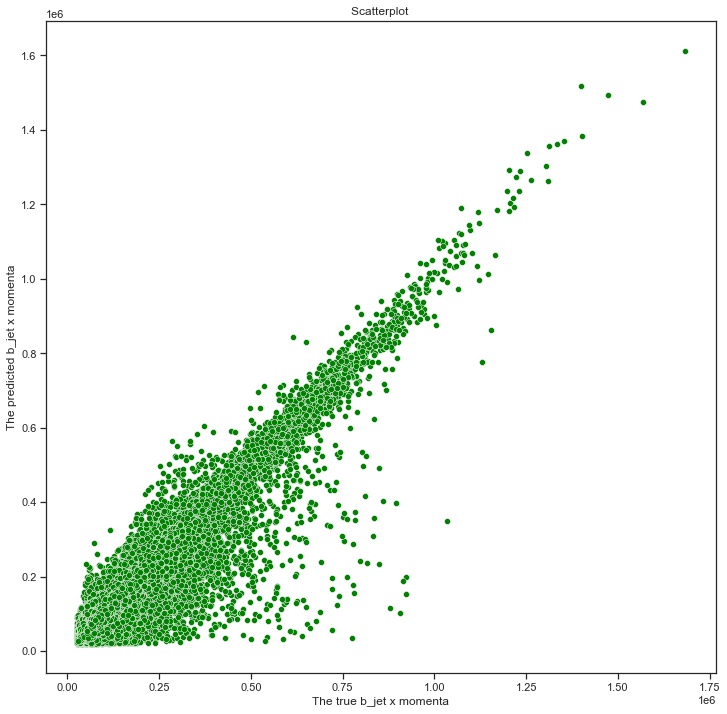

In [30]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = jets[:,0],
    y = rejets[:,0],
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_ylabel("The predicted b_jet x momenta")
ax.set_xlabel("The true b_jet x momenta")
plt.show()

In [31]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [32]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
def kde_generator(x,y, ax, s, alpha, cmap):
    grid = np.vstack([x, y])
    z = gaussian_kde(grid)(grid)
    idx = z.argsort()
    x,y,z = x[idx], y[idx], z[idx]
    im = sns.scatterplot(x,y,c = z,s = s, ax = ax, alpha = alpha, cmap = cmap)
    norm = plt.Normalize(z.min(), z.max())
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    #im.figure.colorbar(sm, cax = ax_2, orientation="horizontal", pad=0.2)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    return ax, sm
# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  return ax
  
plt.rcParams.update({'font.size': 18})
from sklearn.metrics import r2_score
from hffrag import binneddensitysub

In [38]:
plt.rcParams.update({'font.size': 24})
from sklearn.metrics import r2_score
from hffrag import binneddensitysub

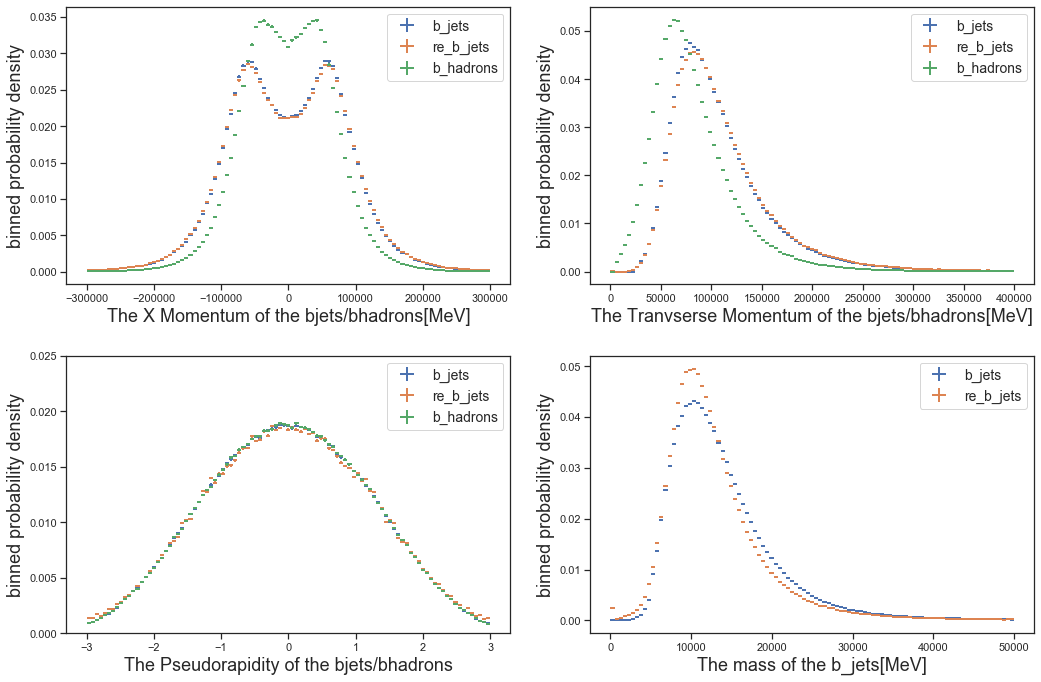

In [55]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "b_jets")
binneddensitysub(re_b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons [MeV]", label = "re_b_jets")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the bjets/bhadrons[MeV]", label = "b_hadrons")
binneddensitysub(b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets[MeV]", label = "b_jets")
binneddensitysub(re_b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets[MeV]", label = "re_b_jets")
binneddensitysub(bhads_pt, fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the bjets/bhadrons[MeV]", label = "b_hadrons")
binneddensitysub(b_jets[:,4], fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,4], fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_eta, fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets[MeV]", label = "re_b_jets")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
axes[1,0].set_ylim([0,0.025])
plt.tight_layout()
plt.rc("axes",labelsize = 18)
axes[0,0].legend(fontsize = 14)
axes[0,1].legend(fontsize = 14)
axes[1,0].legend(fontsize = 14)
axes[1,1].legend(fontsize = 14)
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Jets_DistributionsUpdated.png", dpi = 500)

In [44]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)
sum_tracks_px = np.ma.sum(tracks[:,:,0],axis = 1)
sum_tracks_py = np.ma.sum(tracks[:,:,1],axis = 1)
sum_tracks_pz = np.ma.sum(tracks[:,:,2],axis = 1)
sum_tracks_pt = np.ma.sum(tracks[:,:,3],axis = 1)

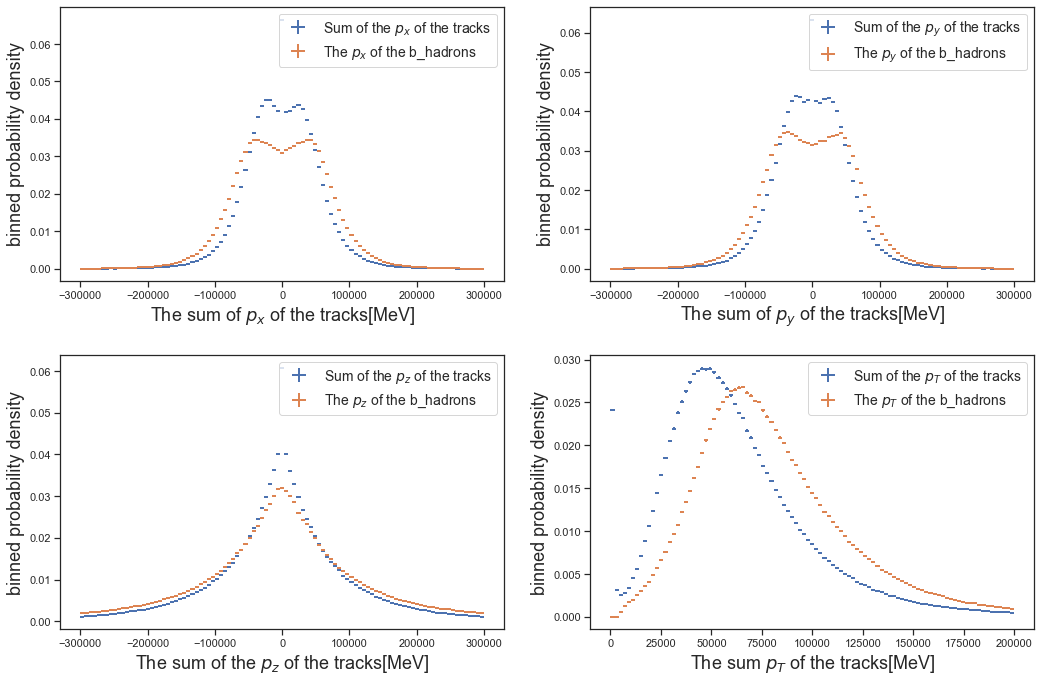

In [54]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(sum_tracks_px, fixedbinning(-3e5,3e5,100), ax = axes[0,0], xlabel="Sum of the X Momentum of the tracks", label = "Sum of the $p_x$ of the tracks")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The sum of $p_x$ of the tracks[MeV]", label = "The $p_x$ of the b_hadrons")
binneddensitysub(sum_tracks_py, fixedbinning(-3e5,3e5,100), ax = axes[0,1], label="Sum of the $p_y$ of the tracks" )
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[0,1], xlabel = "The sum of $p_y$ of the tracks[MeV]", label = "The $p_y$ of the b_hadrons")
binneddensitysub(sum_tracks_pz, fixedbinning(-3e5,3e5,100), ax = axes[1,0], xlabel="Sum of the Z Momentum of the tracks", label = "Sum of the $p_z$ of the tracks")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[1,0], xlabel = "The sum of the $p_z$ of the tracks[MeV]", label = "The $p_z$ of the b_hadrons")
binneddensitysub(sum_tracks_pt, fixedbinning(0,2e5,100), ax = axes[1,1], xlabel="The sum of the Transverse Momentum of the tracks", label = "Sum of the $p_T$ of the tracks")
binneddensitysub(bhads_pt, fixedbinning(0, 2e5,100), ax = axes[1,1], xlabel = "The sum $p_T$ of the tracks[MeV]", label = "The $p_T$ of the b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.tight_layout()
plt.rc("axes",labelsize = 18)
axes[0,0].legend(fontsize = 14)
axes[0,1].legend(fontsize = 14)
axes[1,0].legend(fontsize = 14)
axes[1,1].legend(fontsize = 14)
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Sum_Of_Tracks_Distributions.png", dpi = 500)

In [ ]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(sum_tracks_px, fixedbinning(-3e5,3e5,100), ax = axes[0,0], xlabel="Sum of the X Momentum of the tracks", label = "Sum of the $p_x$ of the tracks")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momenta", label = "The $p_x$ of the bhadrons")
binneddensitysub(sum_tracks_py, fixedbinning(-3e5,3e5,100), ax = axes[0,1], label="Sum of the $p_y$ of the tracks" )
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[0,1], xlabel = "The Y Momenta", label = "The $p_y$ of the b_hadrons")
binneddensitysub(sum_tracks_pz, fixedbinning(-3e5,3e5,100), ax = axes[1,0], xlabel="Sum of the Z Momentum of the tracks", label = "Sum of the $p_z$ of the tracks")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[1,0], xlabel = "The Z Momenta", label = "The $p_z$ of the b_hadrons")
binneddensitysub(sum_tracks_pt, fixedbinning(0,2e5,100), ax = axes[1,1], xlabel="The sum of the Transverse Momentum of the tracks", label = "Sum of the $p_T$ of the tracks")
binneddensitysub(bhads_pt, fixedbinning(0, 2e5,100), ax = axes[1,1], xlabel = "The Tranvserse Momenta", label = "The $p_T$ of the b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.tight_layout()
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Sum_Of_Tracks_Distributions.png", dpi = 500)

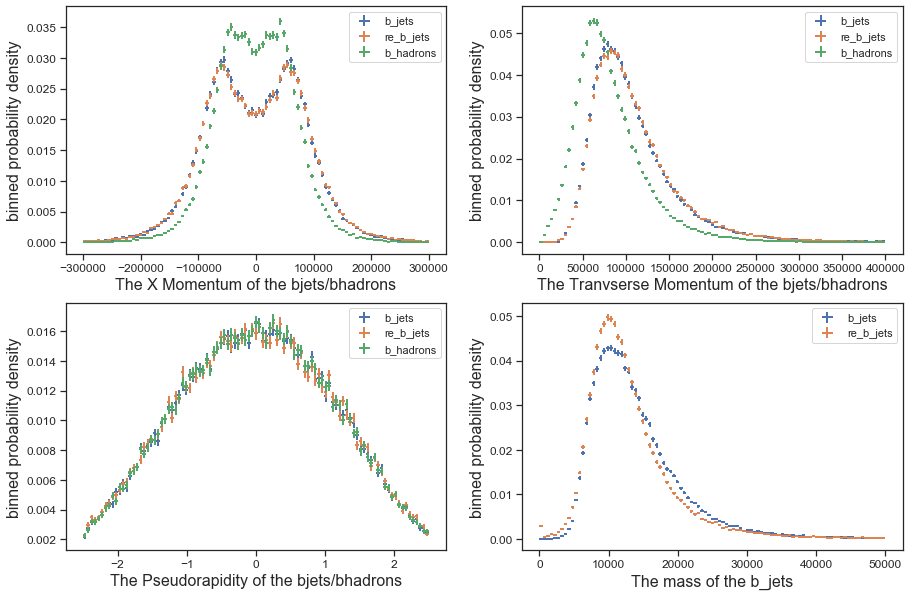

In [150]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "b_jets")
binneddensitysub(re_b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "re_b_jets")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_pt, fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,4], fixedbinning(-2.5, 2.5,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,4], fixedbinning(-2.5, 2.5,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_eta, fixedbinning(-2.5, 2.5,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets", label = "re_b_jets")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Jets_DistributionsUpdated.png", dpi = 500)

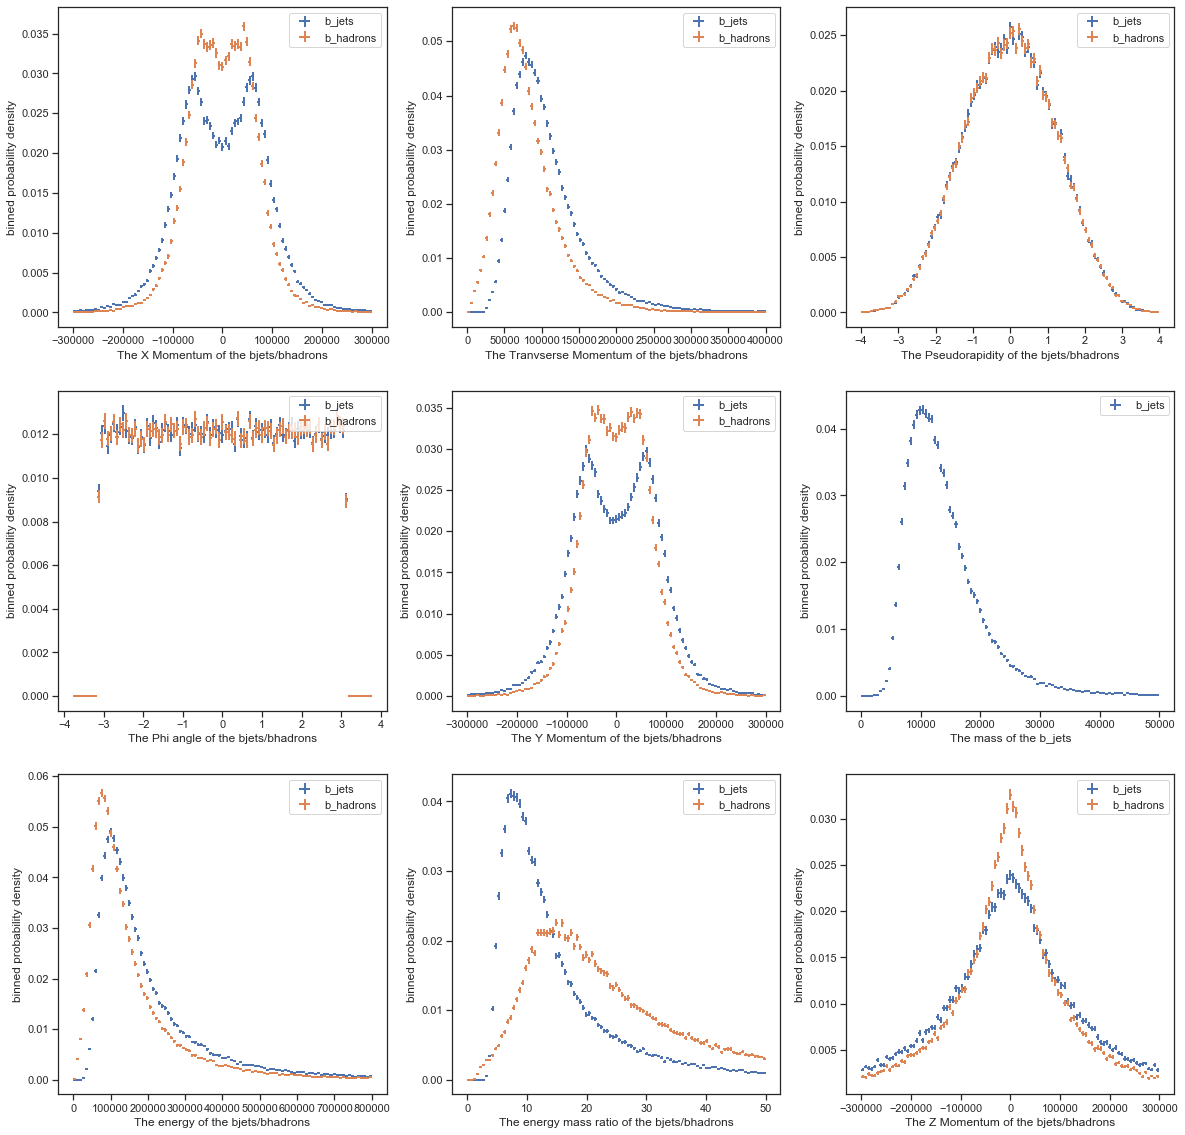

In [117]:
#Plots the distribution of the transverse momenta of the b-jets
Figure, axes = plt.subplots(3,3, figsize = (20,20))
binneddensitysub(b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "b_jets")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[1,1], xlabel = "The Y Momentum of the bjets/bhadron", label = "b_jets")
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[1,1], xlabel = "The Y Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[2,2], xlabel = "The Z Momentum of b_jets", label = "b_jets")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[2,2], xlabel = "The Z Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "b_jets")
binneddensitysub(bhads_pt, fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,4], fixedbinning(-4, 4,100), ax = axes[0,2], xlabel = "The Pseudorapidity of the b_jets", label = "b_jets")
binneddensitysub(bhads_eta, fixedbinning(-4, 4,100), ax = axes[0,2], xlabel = "The Pseudorapidity of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,5], fixedbinning(-1.2*np.pi, 1.2*np.pi,100), ax = axes[1,0], xlabel = "The Phi angle of the b_jets", label = "b_jets")
binneddensitysub(bhads_phi, fixedbinning(-1.2*np.pi, 1.2*np.pi,100), ax = axes[1,0], xlabel = "The Phi angle of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,2], xlabel = "The mass of the b_jets", label = "b_jets")
binneddensitysub(b_jets[:,7], fixedbinning(2, 8e5,100), ax = axes[2,0], xlabel = "The energy of the bjets/bhadrons", label = "b_jets")
binneddensitysub(bhads_energy, fixedbinning(2, 8e5,100), ax = axes[2,0], xlabel = "The energy of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,8], fixedbinning(0, 50,100), ax = axes[2,1], xlabel = "The energy mass ratio of the bjets/bhadrons", label = "b_jets")
binneddensitysub(bhads_energy_mass_ratio, fixedbinning(0, 50,100), ax = axes[2,1], xlabel = "The energy mass ratio of the bjets/bhadrons", label = "b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/B_jets_DistributionsUpdated.png", dpi = 500)

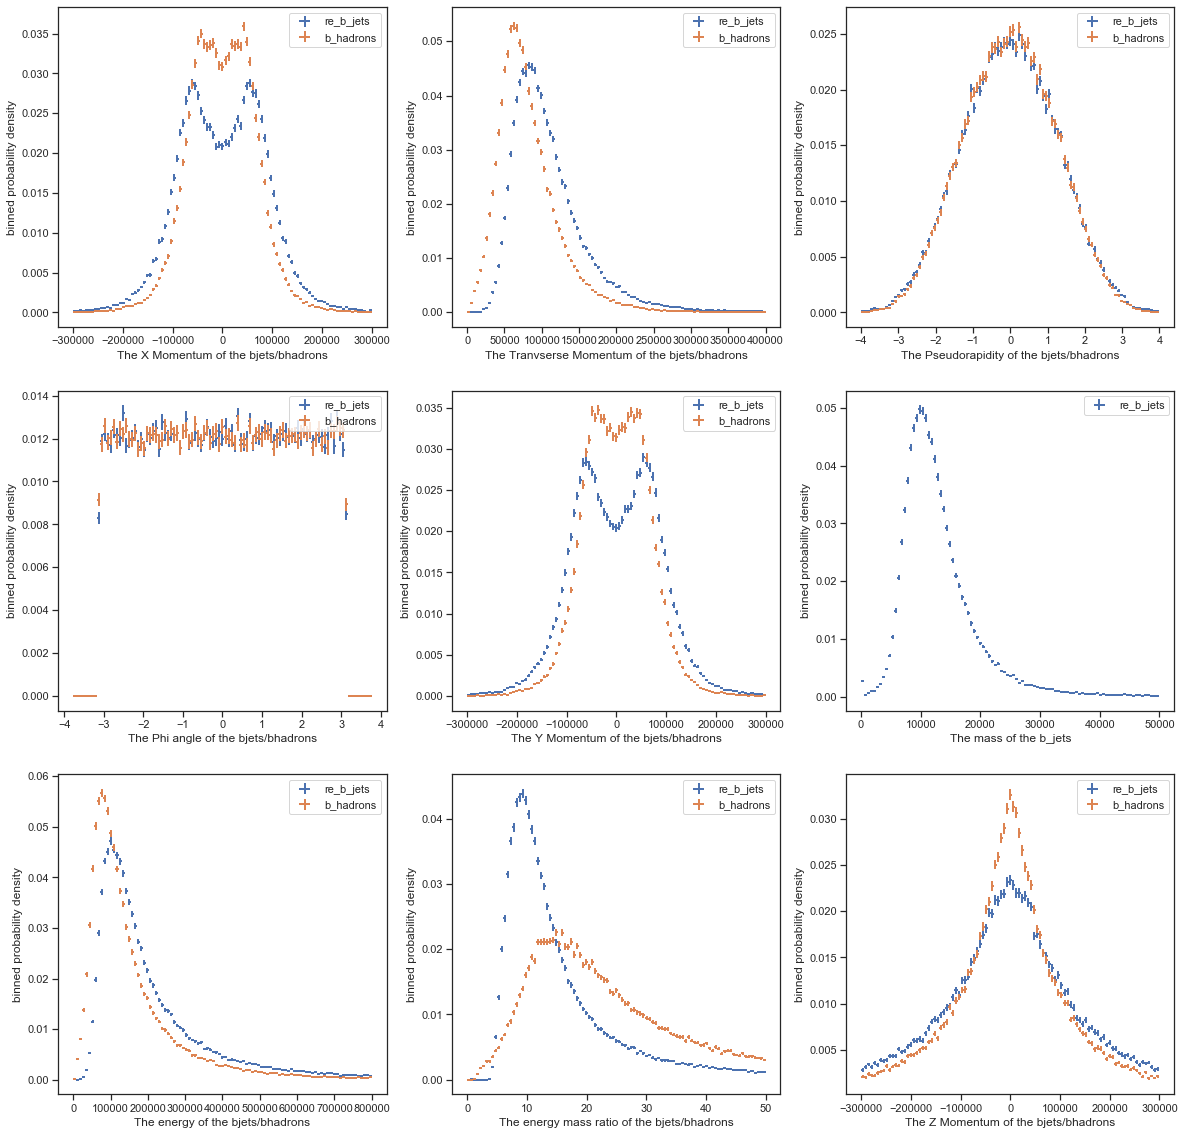

In [143]:
#Plots the distribution of the transverse momenta of the b-jets
Figure, axes = plt.subplots(3,3, figsize = (20,20))
binneddensitysub(re_b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "re_b_jets")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[1,1], xlabel = "The Y Momentum of the bjets/bhadron", label = "re_b_jets")
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[1,1], xlabel = "The Y Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[2,2], xlabel = "The Z Momentum of b_jets", label = "re_b_jets")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[2,2], xlabel = "The Z Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_pt, fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,4], fixedbinning(-4, 4,100), ax = axes[0,2], xlabel = "The Pseudorapidity of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_eta, fixedbinning(-4, 4,100), ax = axes[0,2], xlabel = "The Pseudorapidity of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,5], fixedbinning(-1.2*np.pi, 1.2*np.pi,100), ax = axes[1,0], xlabel = "The Phi angle of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_phi, fixedbinning(-1.2*np.pi, 1.2*np.pi,100), ax = axes[1,0], xlabel = "The Phi angle of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,2], xlabel = "The mass of the b_jets", label = "re_b_jets")
binneddensitysub(re_b_jets[:,7], fixedbinning(2, 8e5,100), ax = axes[2,0], xlabel = "The energy of the bjets/bhadrons", label = "re_b_jets")
binneddensitysub(bhads_energy, fixedbinning(2, 8e5,100), ax = axes[2,0], xlabel = "The energy of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(re_b_jets[:,8], fixedbinning(0, 50,100), ax = axes[2,1], xlabel = "The energy mass ratio of the bjets/bhadrons", label = "re_b_jets")
binneddensitysub(bhads_energy_mass_ratio, fixedbinning(0, 50,100), ax = axes[2,1], xlabel = "The energy mass ratio of the bjets/bhadrons", label = "b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Reconstructured_B_jets_Distributions.png", dpi = 500)

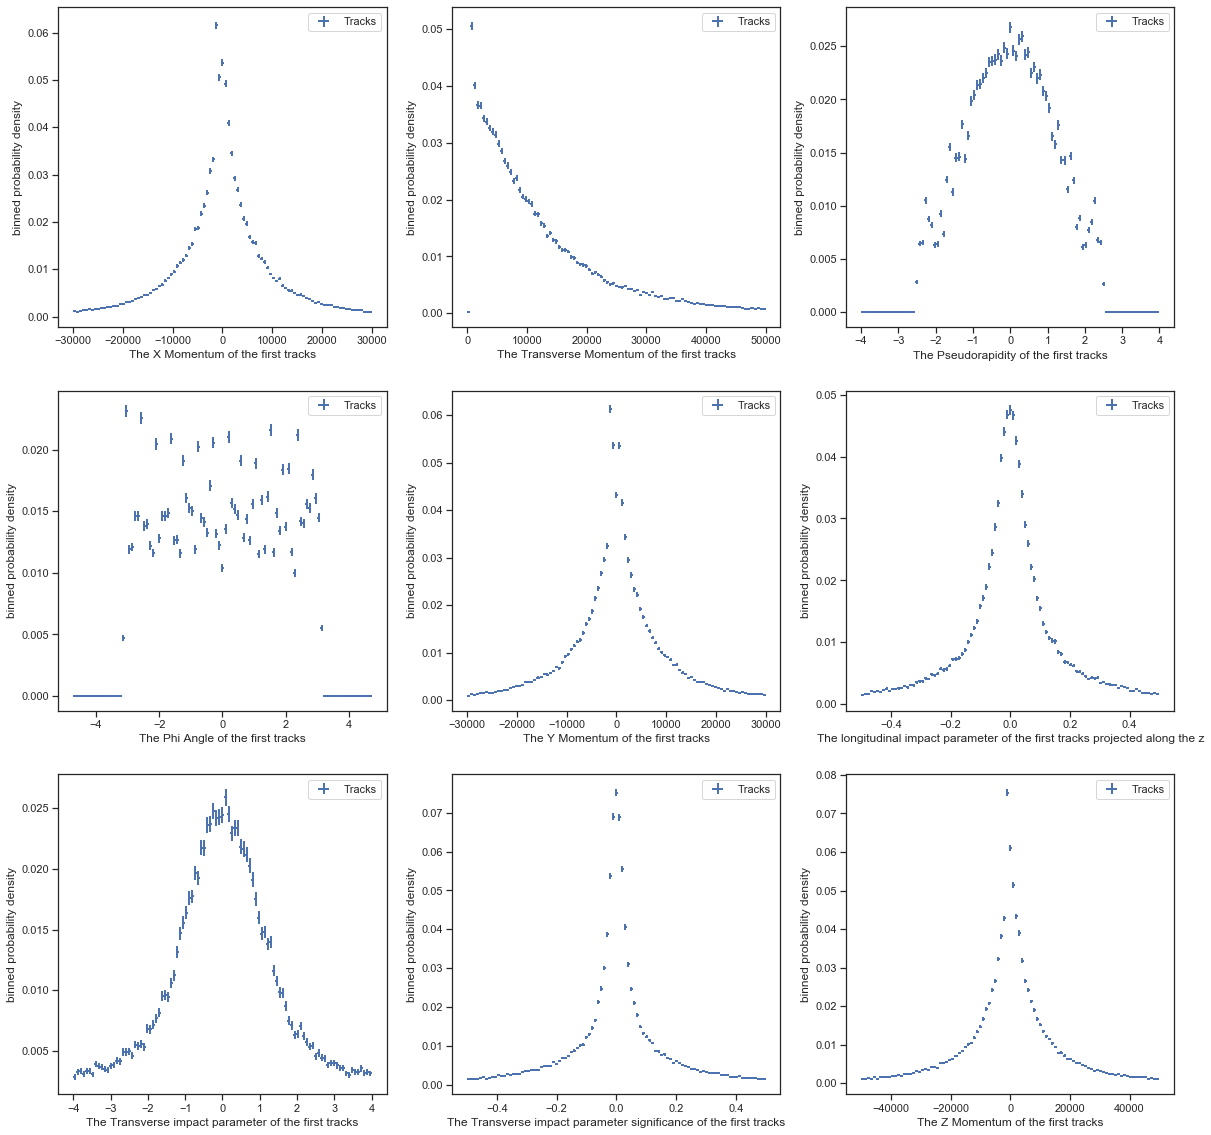

In [24]:
Figure, axes = plt.subplots(3,3, figsize = (20,20))
binneddensitysub(tracks[:,0,0], fixedbinning(-3e4, 3e4, 100), ax = axes[0,0], xlabel="The X Momentum of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,1], fixedbinning(-3e4, 3e4, 100), ax = axes[1,1], xlabel="The Y Momentum of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,2], fixedbinning(-5e4, 5e4, 100), ax = axes[2,2], xlabel="The Z Momentum of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,3], fixedbinning(0, 5e4, 100), ax = axes[0,1], xlabel="The Transverse Momentum of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,4], fixedbinning(-4, 4, 100), ax = axes[0,2], xlabel="The Pseudorapidity of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,5], fixedbinning(-1.5*np.pi,1.5*np.pi, 100), ax = axes[1,0], xlabel="The Phi Angle of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,6], fixedbinning(-0.5, 0.5, 100), ax = axes[1,2], xlabel="The longitudinal impact parameter of the first tracks projected along the z", label = "Tracks")
binneddensitysub(tracks[:,0,7], fixedbinning(-4.0, 4.0, 100), ax = axes[2,0], xlabel="The Transverse impact parameter of the first tracks", label = "Tracks")
binneddensitysub(tracks[:,0,8], fixedbinning(-0.5, 0.5, 100), ax = axes[2,1], xlabel="The Transverse impact parameter significance of the first tracks", label = "Tracks")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Tracks_Distributions.png", dpi = 500)

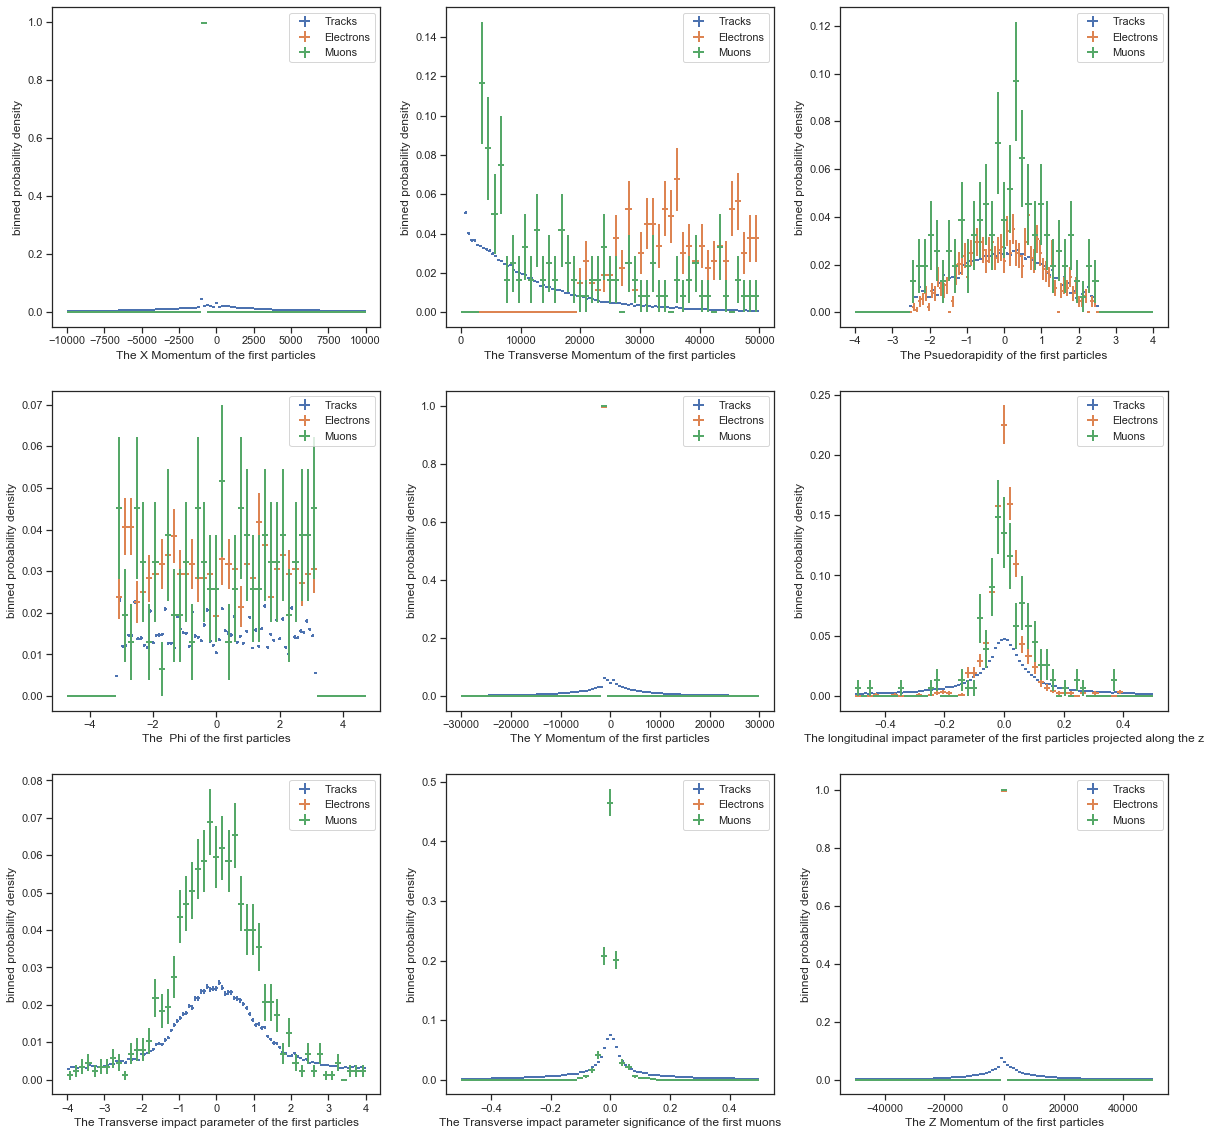

In [120]:
Figure, axes = plt.subplots(3,3, figsize = (20,20))
binneddensitysub(tracks[:,0,0], fixedbinning(-1e4, 1e4, 100), ax = axes[0,0], xlabel="The X Momentum of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,0], fixedbinning(-1e4, 1e4, 50), ax = axes[0,0], xlabel="The X Momentum of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,0], fixedbinning(-1e4, 1e4, 50), ax = axes[0,0], xlabel="The X Momentum of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,1], fixedbinning(-3e4, 3e4, 100), ax = axes[1,1], xlabel="The Y Momentum of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,1], fixedbinning(-3e4, 3e4, 50), ax = axes[1,1], xlabel="The Y Momentum of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,1], fixedbinning(-3e4, 3e4, 50), ax = axes[1,1], xlabel="The Y Momentum of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,2], fixedbinning(-5e4, 5e4, 100), ax = axes[2,2], xlabel="The Z Momentum of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,2], fixedbinning(-5e4, 5e4, 50), ax = axes[2,2], xlabel="The Z Momentum of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,2], fixedbinning(-5e4, 5e4, 50), ax = axes[2,2], xlabel="The Z Momentum of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,3], fixedbinning(0, 5e4, 100), ax = axes[0,1], xlabel="The Transverse Momentum of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,3], fixedbinning(0, 5e4, 50), ax = axes[0,1], xlabel="The Transverse Momentum of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,3], fixedbinning(0, 5e4, 50), ax = axes[0,1], xlabel="The Transverse Momentum of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,4], fixedbinning(-4, 4, 100), ax = axes[0,2], xlabel="The Pseudorapidity of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,4], fixedbinning(-4, 4, 100), ax = axes[0,2], xlabel="The Psuedorapidity of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,4], fixedbinning(-4, 4, 50), ax = axes[0,2], xlabel="The Psuedorapidity of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,5], fixedbinning(-1.5*np.pi,1.5*np.pi, 100), ax = axes[1,0], xlabel="The Phi Angle of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,5], fixedbinning(-1.5*np.pi,1.5*np.pi, 50), ax = axes[1,0], xlabel="The  Phi of the first electrons", label = "Electrons")
binneddensitysub(muons[:,0,5], fixedbinning(-1.5*np.pi,1.5*np.pi, 50), ax = axes[1,0], xlabel="The  Phi of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,6], fixedbinning(-0.5, 0.5, 100), ax = axes[1,2], xlabel="The longitudinal impact parameter of the first tracks projected along the z", label = "Tracks")
binneddensitysub(electrons[:,0,6], fixedbinning(-0.5,0.5, 50), ax = axes[1,2], xlabel="The longitudinal impact parameter of the first electrons projected along the z", label = "Electrons")
binneddensitysub(muons[:,0,6], fixedbinning(-0.5,0.5, 50), ax = axes[1,2], xlabel="The longitudinal impact parameter of the first particles projected along the z", label = "Muons")
binneddensitysub(tracks[:,0,7], fixedbinning(-4.0, 4.0, 100), ax = axes[2,0], xlabel="The Transverse impact parameter of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,7], fixedbinning(-4.0,4.0, 50), ax = axes[2,0], xlabel="The Transverse impact parameter of the first electrons", label = "Electrons")
binneddensitysub(electrons[:,0,7], fixedbinning(-4.0,4.0, 50), ax = axes[2,0], xlabel="The Transverse impact parameter of the first particles", label = "Muons")
binneddensitysub(tracks[:,0,8], fixedbinning(-0.5, 0.5, 100), ax = axes[2,1], xlabel="The Transverse impact parameter significance of the first tracks", label = "Tracks")
binneddensitysub(electrons[:,0,8], fixedbinning(-0.5,0.5, 50), ax = axes[2,1], xlabel="The Transverse impact parameter significance of the first electrons", label = "Electrons")
binneddensitysub(electrons[:,0,8], fixedbinning(-0.5,0.5, 50), ax = axes[2,1], xlabel="The Transverse impact parameter significance of the first muons", label = "Muons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Particles_Distributions.png", dpi = 500)

In [68]:
print(bhads[:,0])
print(bhads_targets[:,0])

[ 53148.34789845  18771.5334753   28981.68692197 ...  59036.29438614
  42550.98466356 -47717.70957954]
[ 5.31483479e+04  5.77737915e+04 -2.18681572e+05  7.85019609e+04
 -1.74840260e+00  8.27073932e-01  1.00088651e+00  9.92290504e-01
  2.32404952e+05]


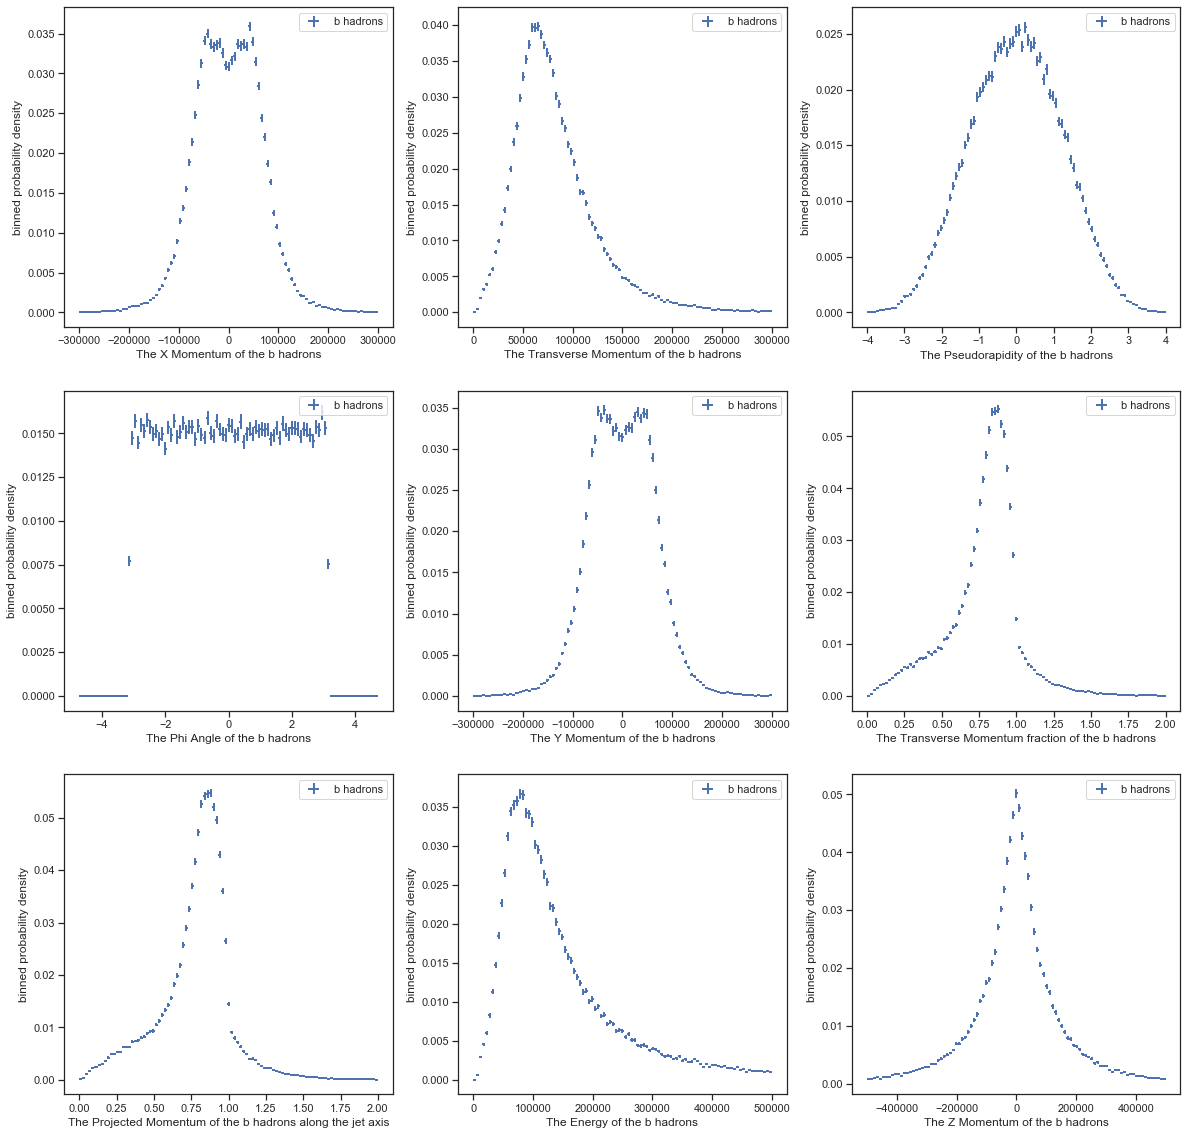

In [22]:
Figure, axes = plt.subplots(3,3, figsize = (20,20))
binneddensitysub(bhads_targets[:,0], fixedbinning(-3e5,3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,1], fixedbinning(-3e5,3e5,100), ax = axes[1,1], xlabel = "The Y Momentum of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,2], fixedbinning(-5e5,5e5,100), ax = axes[2,2], xlabel = "The Z Momentum of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,3], fixedbinning(0,3e5,100), ax = axes[0,1], xlabel = "The Transverse Momentum of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,4], fixedbinning(-4,4,100), ax = axes[0,2], xlabel = "The Pseudorapidity of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,5], fixedbinning(-1.5*np.pi,1.5*np.pi,100), ax = axes[1,0], xlabel = "The Phi Angle of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,6], fixedbinning(0,2,100), ax = axes[1,2], xlabel = "The Transverse Momentum fraction of the b hadrons", label = "b hadrons")
binneddensitysub(bhads_targets[:,7], fixedbinning(0,2,100), ax = axes[2,0], xlabel = "The Projected Momentum of the b hadrons along the jet axis", label = "b hadrons")
binneddensitysub(bhads_targets[:,8], fixedbinning(0,5e5,100), ax = axes[2,1], xlabel = "The Energy of the b hadrons", label = "b hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Bhadrons_Distributions.png", dpi = 500)

In [31]:
# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs

In [84]:
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  return ax

In [83]:
plt.rcParams.update({'font.size': 18})

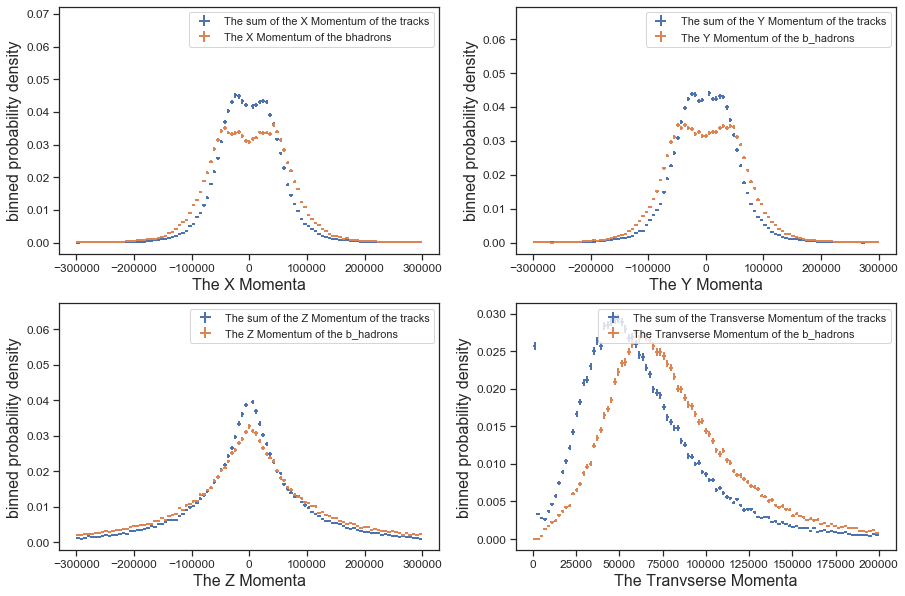

In [86]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(sum_tracks_px, fixedbinning(-3e5,3e5,100), ax = axes[0,0], xlabel="Sum of the X Momentum of the tracks", label = "The sum of the X Momentum of the tracks")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momenta", label = "The X Momentum of the bhadrons")
binneddensitysub(sum_tracks_py, fixedbinning(-3e5,3e5,100), ax = axes[0,1], xlabel="Sum of the Y Momentum of the tracks", label = "The sum of the Y Momentum of the tracks" )
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[0,1], xlabel = "The Y Momenta", label = "The Y Momentum of the b_hadrons")
binneddensitysub(sum_tracks_pz, fixedbinning(-3e5,3e5,100), ax = axes[1,0], xlabel="Sum of the Z Momentum of the tracks", label = "The sum of the Z Momentum of the tracks")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[1,0], xlabel = "The Z Momenta", label = "The Z Momentum of the b_hadrons")
binneddensitysub(sum_tracks_pt, fixedbinning(0,2e5,100), ax = axes[1,1], xlabel="The sum of the Transverse Momentum of the tracks", label = "The sum of the Transverse Momentum of the tracks")
binneddensitysub(bhads_pt, fixedbinning(0, 2e5,100), ax = axes[1,1], xlabel = "The Tranvserse Momenta", label = "The Tranvserse Momentum of the b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Sum_Of_Tracks_Distributions.png", dpi = 500)

In [88]:
np.mean(bhads_pt/sum_tracks_pt)

1.9650294714769312

In [77]:
mask_0 = (sum_tracks_pt <= -1e4) | (sum_tracks_pt >= 1e4)
mask_1 = (sum_tracks_px <= -1e4) | (sum_tracks_px >= 1e4)
mask_2 = (sum_tracks_py <= -1e4) | (sum_tracks_py >= 1e4)
mask_3 = (sum_tracks_pz <= -1e5) | (sum_tracks_pz >= 1e5)
a = sum_tracks_px[mask_1]
a[a < 1e4]
from sklearn.feature_selection import r_regression
print(sum_tracks_pt.shape, bhads_pt.shape)
a = r_regression(np.array([sum_tracks_pt, sum_tracks_px, sum_tracks_py, sum_tracks_pz]).reshape(-1,4), bhads_pt)
b = r_regression(np.array([sum_tracks_pt, sum_tracks_px, sum_tracks_py, sum_tracks_pz]).reshape(-1,4), bhads[:,0])
c = r_regression(np.array([sum_tracks_pt, sum_tracks_px, sum_tracks_py, sum_tracks_pz]).reshape(-1,4), bhads[:,1])
d = r_regression(np.array([sum_tracks_pt, sum_tracks_px, sum_tracks_py, sum_tracks_pz]).reshape(-1,4), bhads[:,2])

(96659,) (96659,)


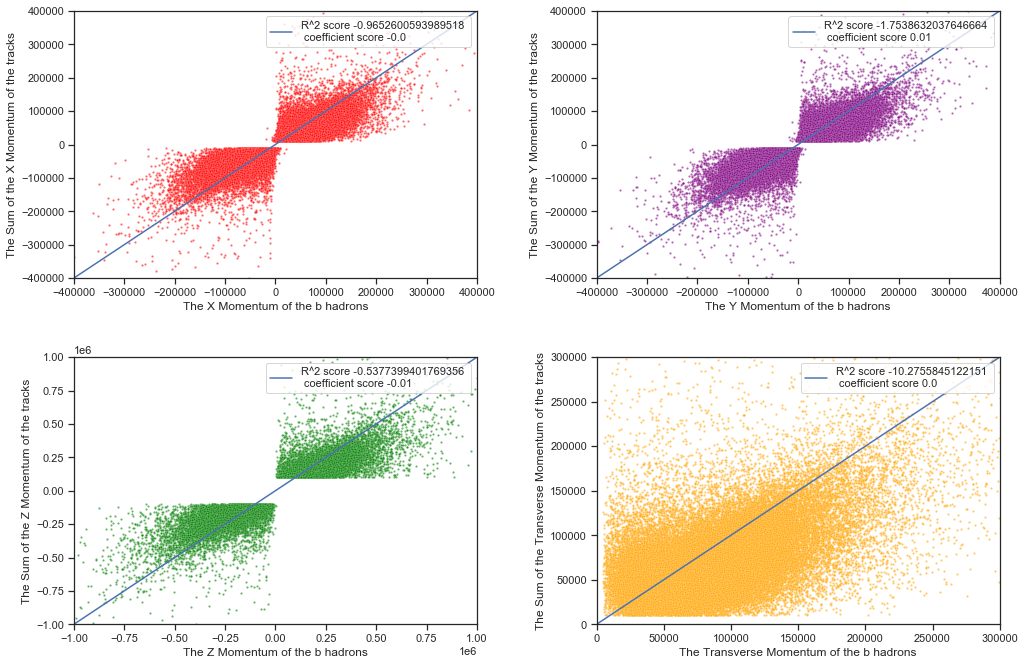

In [79]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
l1 = sns.scatterplot(x = bhads[:,0][mask_1], y = sum_tracks_px[mask_1], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(bhads[:,0], sum_tracks_px)
l1_coeff = a[0]
x = np.linspace(-4e5, 4e5)
l1.plot(x,x)
l1.set_xlabel("The X Momentum of the b hadrons")
l1.set_ylabel("The Sum of the X Momentum of the tracks")
l2 = sns.scatterplot(x = bhads[:,1][mask_2], y = sum_tracks_py[mask_2], ax = axes[0,1], s = 5, alpha = 0.6, color = "purple")
l2.set_xlabel("The Y Momentum of the b hadrons")
l2_score = r2_score(bhads[:,1], sum_tracks_py)
l2_coeff = b[1]
x = np.linspace(-4e5, 4e5)
l2.plot(x,x)
l2.set_ylabel("The Sum of the Y Momentum of the tracks")
l3 = sns.scatterplot(x = bhads[:,2][mask_3], y = sum_tracks_pz[mask_3], ax = axes[1,0], s = 5, alpha = 0.6, color = "green")
l3.set_xlabel("The Z Momentum of the b hadrons")
l3.set_ylabel("The Sum of the Z Momentum of the tracks")
l3_score = r2_score(bhads[:,2], sum_tracks_pz)
l3_coeff = c[2]
x = np.linspace(-1e6, 1e6)
l3.plot(x,x)
l4 = sns.scatterplot(x = bhads_pt[mask_0], y = sum_tracks_pt[mask_0], ax = axes[1,1], s = 5, alpha = 0.6, color = "orange")
l4.set_xlabel("The Transverse Momentum of the b hadrons")
l4.set_ylabel("The Sum of the Transverse Momentum of the tracks")
l4_score = r2_score(bhads_pt, sum_tracks_pt)
l4_coeff = d[3]
x = np.linspace(-3e5, 3e5)
l4.plot(x,x)
axes[0,0].set_xlim([-4e5, 4e5])
axes[0,0].legend([f"R^2 score {l1_score} \n coefficient score {round(l1_coeff,2)}"], loc = "upper right")
axes[0,0].set_ylim([-4e5, 4e5])
axes[0,1].set_xlim([-4e5, 4e5])
axes[0,1].legend([f"R^2 score {l2_score} \n coefficient score {round(l2_coeff,2)}"], loc = "upper right")
axes[0,1].set_ylim([-4e5, 4e5])
axes[1,0].set_xlim([-1e6, 1e6])
axes[1,0].legend([f"R^2 score {l3_score} \n coefficient score {round(l3_coeff,2)}"], loc = "upper right")
axes[1,0].set_ylim([-1e6, 1e6])
axes[1,1].set_xlim([0, 3e5])
axes[1,1].legend([f"R^2 score {l4_score} \n coefficient score {round(l4_coeff,2)}"], loc = "upper right")
axes[1,1].set_ylim([0, 3e5])
plt.tight_layout()
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/SumTracks_Scatterplots.png", dpi = 500)

In [194]:
input = np.concatenate([tracks.reshape(len(b_jets), -1), b_jets], axis = -1)
input.shape

(96659, 361)

In [118]:
rejets.shape

(96659, 4)

In [168]:
inputs = np.stack([b_jets[:,0], b_jets[:,1], b_jets[:,2], b_jets[:,3], sum_tracks_pt, sum_tracks_px, sum_tracks_py, sum_tracks_pz], axis = -1)
inputs.shape

(96659, 8)

In [169]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 3,  include_bias = False)
input_poly = poly_features.fit_transform(inputs)

In [170]:
input_poly.shape

(96659, 164)

In [171]:
X_train, X_valid, y_train, y_valid = train_test_split(b_jets,bhads_targets, test_size= 0.3, random_state=42)
print(X_train.shape,X_valid.shape)
print(y_train.shape, y_valid.shape)

(67661, 9) (28998, 9)
(67661, 9) (28998, 9)


In [172]:
reg = Ridge(alpha = 1.0)
reg.fit(X_train, y_train)
results = reg.predict(X_valid)

/home/physics/phujdj/anaconda3/envs/SpocFit/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.98885e-12): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [173]:
results = reg.predict(X_valid)

In [174]:
print(y_valid[1,6], results[1,6])

0.8708567395433285 0.87967527


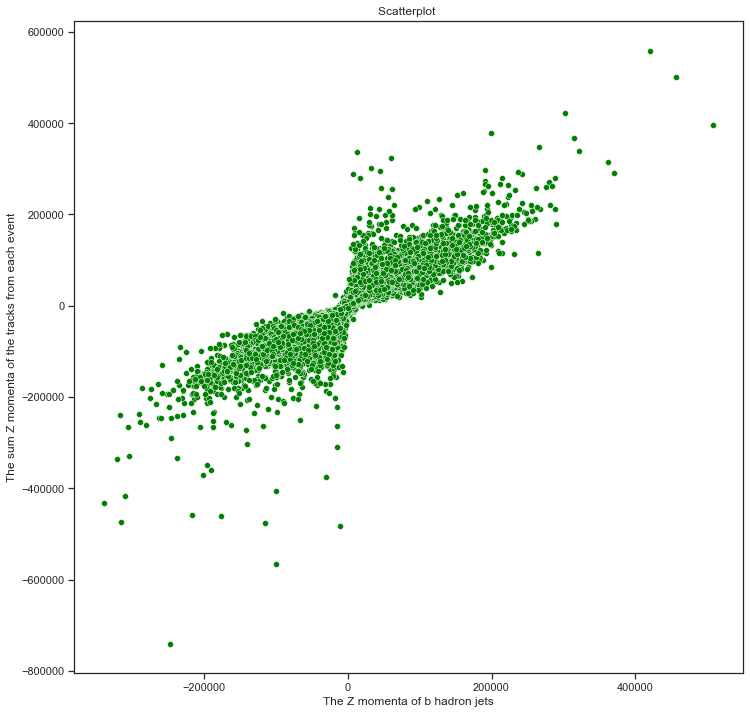

In [175]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = y_valid[:,0],
    y = results[:,0],
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_ylabel("The sum Z momenta of the tracks from each event")
ax.set_xlabel("The Z momenta of b hadron jets")
plt.show()

In [119]:
b_jets.shape

(96659, 9)

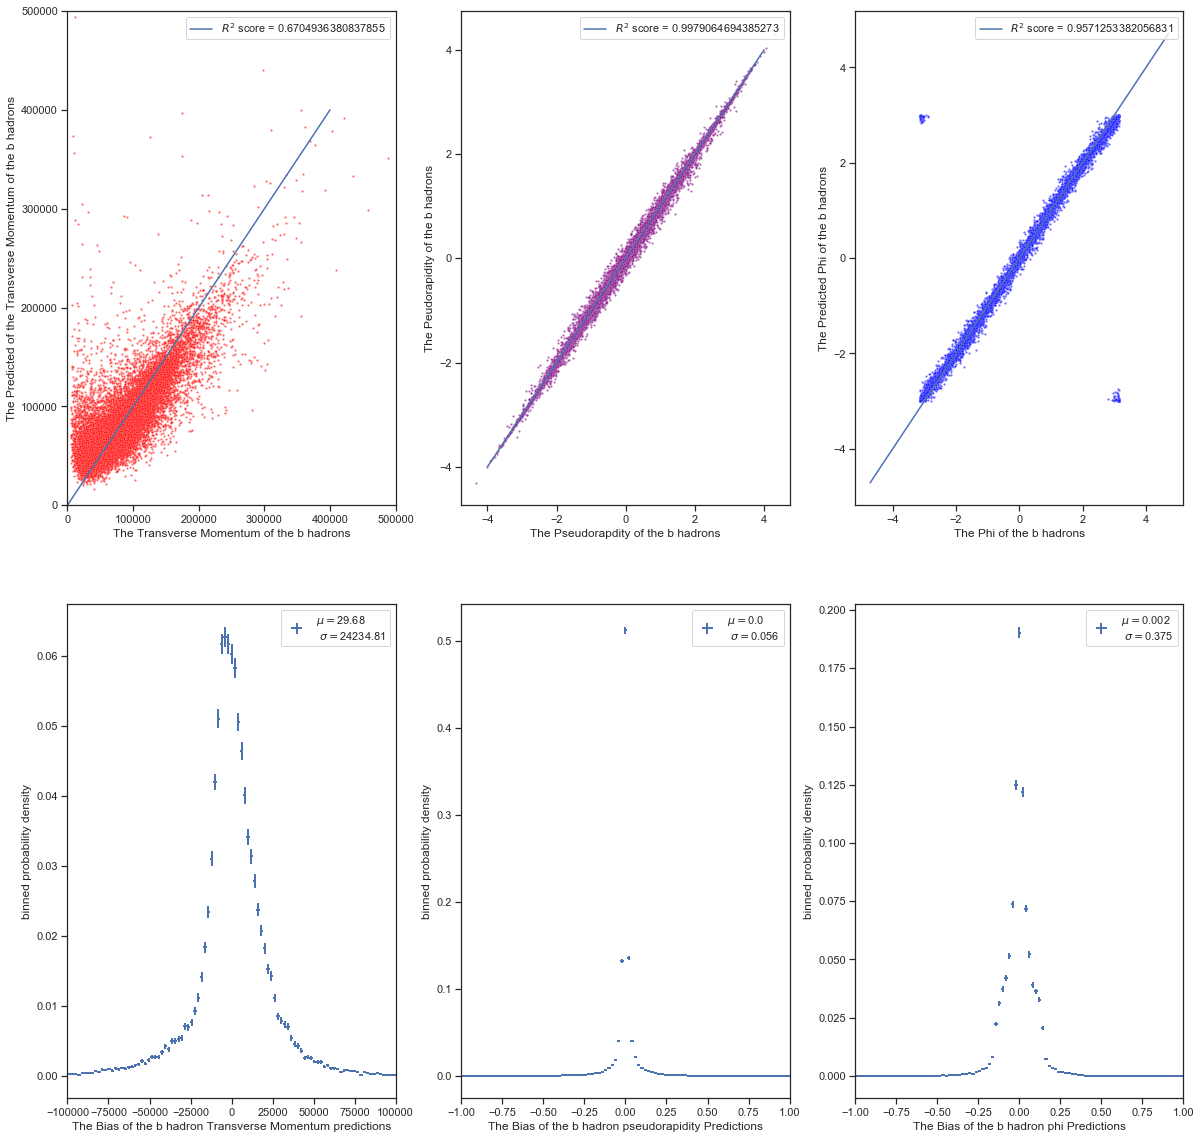

In [176]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = y_valid[:,3], y = results[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(y_valid[:,3], results[:,3])
x = np.linspace(0, 4e5)
l1.set_xlabel("The Transverse Momentum of the b hadrons")
l1.set_ylabel("The Predicted of the Transverse Momentum of the b hadrons")
error_pt = y_valid[:,3] - results[:,3]
mean_error_pt, std_error_pt = np.mean(error_pt), np.std(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(-1e5,1e5,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum predictions")
l2 = sns.scatterplot(x = y_valid[:,4], y = results[:,4], ax = axes[0,1], s = 5, alpha = 0.6, color = "purple")
l2_score = r2_score(y_valid[:,4], results[:,4])
x = np.linspace(-4, 4)
error_pseudorapidity = y_valid[:,4] - results[:,4]
mean_error_pseudorapidity, std_error_psuedorapidity = np.mean(error_pseudorapidity), np.std(error_pseudorapidity)
l2.plot(x,x)
l2.set_xlabel("The Pseudorapdity of the b hadrons")
l2.set_ylabel("The Peudorapidity of the b hadrons")
binneddensitysub(error_pseudorapidity, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Bias of the b hadron pseudorapidity Predictions")
l3 = sns.scatterplot(x = y_valid[:,5], y = results[:,5], ax = axes[0,2], s = 5, alpha = 0.6, color = "blue")
l3_score = r2_score(y_valid[:,5], results[:,5])
x = np.linspace(-1.5*np.pi, 1.5*np.pi)
error_phi = y_valid[:,5] - results[:,5]
mean_error_phi, std_error_phi = np.mean(error_phi), np.std(error_phi)
l3.plot(x,x)
l3.set_xlabel("The Phi of the b hadrons")
l3.set_ylabel("The Predicted Phi of the b hadrons")
binneddensitysub(error_phi, fixedbinning(-1,1,100), ax = axes[1,2], xlabel="The Bias of the b hadron phi Predictions")
axes[0,0].set_ylim(0,5e5)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,5e5)
axes[1,0].set_xlim(-1e5,1e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right")
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].set_xlim(-1,1)
axes[1,1].legend([f"$\mu = ${round(mean_error_pseudorapidity,3)}\n $\sigma = ${round(std_error_psuedorapidity,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_phi,3)}\n $\sigma = ${round(std_error_phi,3)}"], loc = "upper right")
axes[1,2].set_xlim(-1,1)
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/RidgeRegression2.png", dpi = 500)

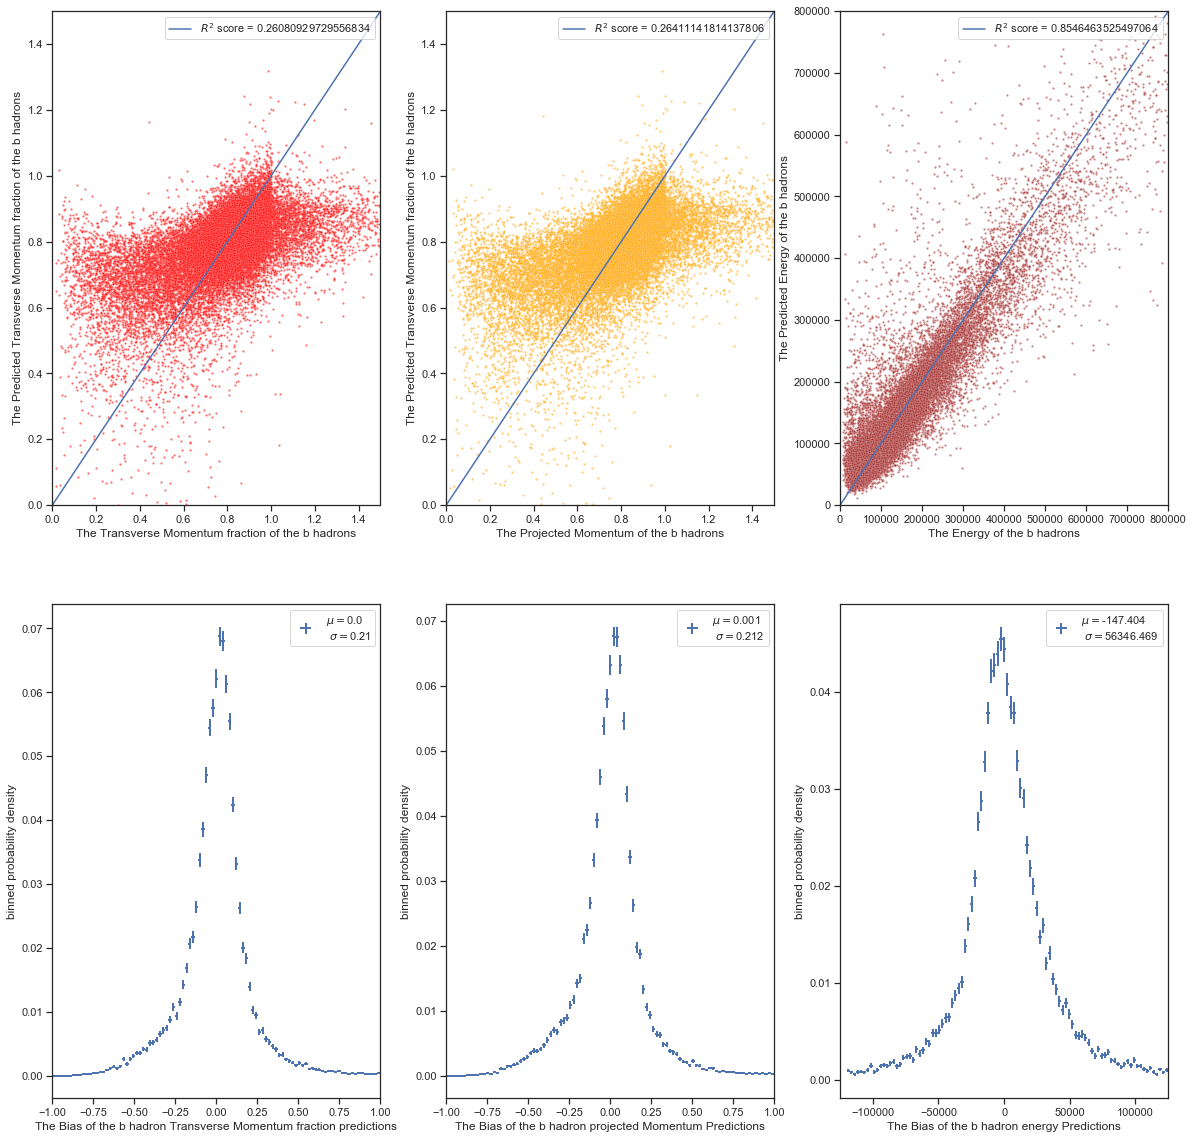

In [177]:
Figure, axes = plt.subplots(2,3, figsize = (20,20))
l1 = sns.scatterplot(x = y_valid[:,6], y = results[:,6], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1_score = r2_score(y_valid[:,6], results[:,6])
x = np.linspace(0, 4)
l1.set_xlabel("The Transverse Momentum fraction of the b hadrons")
l1.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
error_pt_fraction = y_valid[:,6] - results[:,6]
mean_error_pt_fraction, std_error_pt_fraction = np.mean(error_pt_fraction), np.std(error_pt_fraction)
l1.plot(x,x)
binneddensitysub(error_pt_fraction, fixedbinning(-1,1,100), ax = axes[1,0], xlabel= "The Bias of the b hadron Transverse Momentum fraction predictions")
l2 = sns.scatterplot(x = y_valid[:,7], y = results[:,7], ax = axes[0,1], s = 5, alpha = 0.6, color = "orange")
l2_score = r2_score(y_valid[:,7], results[:,7])
x = np.linspace(0, 4)
error_projection = y_valid[:,7] - results[:,7]
mean_error_projection, std_error_projection = np.mean(error_projection), np.std(error_projection)
l2.plot(x,x)
l2.set_xlabel("The Projected Momentum of the b hadrons")
l2.set_ylabel("The Predicted Transverse Momentum fraction of the b hadrons")
binneddensitysub(error_projection, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Bias of the b hadron projected Momentum Predictions")
l3 = sns.scatterplot(x = y_valid[:,8], y = results[:,8], ax = axes[0,2], s = 5, alpha = 0.6, color = "brown")
l3_score = r2_score(y_valid[:,8], results[:,8])
x = np.linspace(0, 3e6)
error_energy = y_valid[:,8] - results[:,8]
mean_error_energy, std_error_energy = np.mean(error_energy), np.std(error_energy)
l3.plot(x,x)
l3.set_xlabel("The Energy of the b hadrons")
l3.set_ylabel("The Predicted Energy of the b hadrons")
binneddensitysub(error_energy, fixedbinning(-1.2e5,1.25e5,100), ax = axes[1,2], xlabel="The Bias of the b hadron energy Predictions")
axes[0,0].set_ylim(0,1.5)
axes[0,0].legend([f"$R^2$ score = {l1_score}"], loc = "upper right")
axes[0,0].set_xlim(0,1.5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt_fraction,2)}\n $\sigma = ${round(std_error_pt_fraction,2)}"], loc = "upper right")
axes[0,1].set_xlim(0,1.5)
axes[0,1].set_ylim(0,1.5)
axes[0,1].legend([f"$R^2$ score = {l2_score}"], loc = "upper right")
axes[1,1].legend([f"$\mu = ${round(mean_error_projection,3)}\n $\sigma = ${round(std_error_projection,3)}"], loc = "upper right")
axes[0,2].legend([f"$R^2$ score = {l3_score}"], loc = "upper right")
axes[1,2].legend([f"$\mu = ${round(mean_error_energy,3)}\n $\sigma = ${round(std_error_energy,3)}"], loc = "upper right")
axes[0,2].set_ylim(0,8e5)
axes[0,2].set_xlim(0,8e5)
axes[1,0].set_xlim(-1,1)
axes[1,1].set_xlim(-1,1)
axes[1,2].set_xlim(-1.25e5,1.25e5)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/RidgeRegression3.png", dpi = 500)

In [208]:
reg.score(X_valid,y_valid)

0.7425293286088265

In [46]:
np.max(tracks[:,0,3])/1e6

6.717349

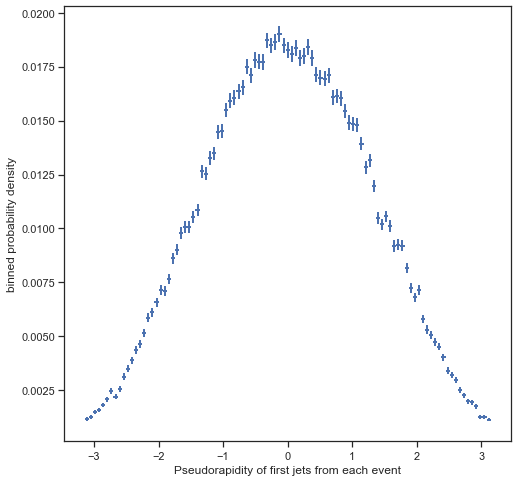

<Figure size 432x288 with 0 Axes>

In [8]:
#Plots the distribution of the pseudorapidities of the b_jets
Figure = plt.figure()
jet_pt_distribution = binneddensity(features["AnalysisAntiKt4TruthJets_eta"][:,0],fixedbinning(-np.pi,np.pi,100),xlabel = "Pseudorapidity of first jets from each event")
jet_pt_distribution

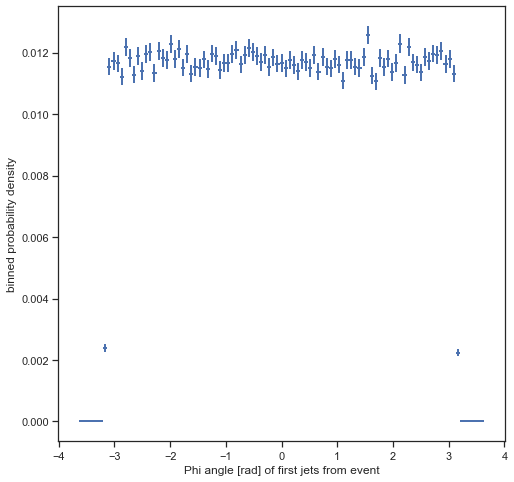

<Figure size 432x288 with 0 Axes>

In [9]:
#Plots the distributions of the phi angles of the b_jets
Figure = plt.figure()
jet_pt_distribution = binneddensity(features["AnalysisAntiKt4TruthJets_phi"][:,0],fixedbinning(-np.pi-0.5,np.pi+0.5,100),xlabel = "Phi angle [rad] of first jets from event")
jet_pt_distribution

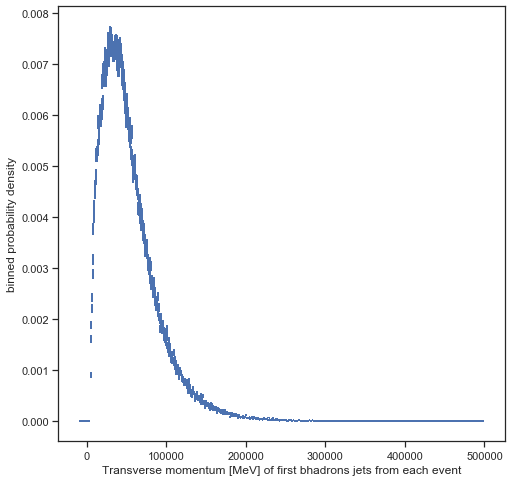

<Figure size 432x288 with 0 Axes>

In [10]:
#Plots the distribution of the transverse momenta of the b hadrons
Figure = plt.figure()
bhadrons = ak.flatten(features["AnalysisAntiKt4TruthJets_ghostB_pt"],axis = None)
jet_bhadron_pt_distribution = binneddensity(bhadrons,fixedbinning(-10000,500000,1000),xlabel = "Transverse momentum [MeV] of first bhadrons jets from each event")
jet_bhadron_pt_distribution

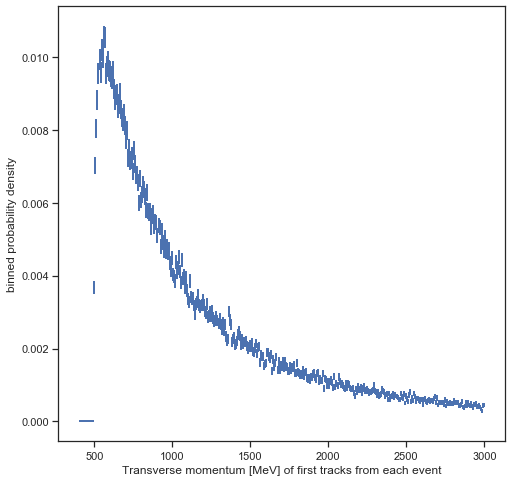

<Figure size 432x288 with 0 Axes>

In [11]:
#Plots the distirbution of the transverse momenta of the tracks
Figure = plt.figure()
Tracks_pt = binneddensity(features["AnalysisTracks_pt"][:,0],fixedbinning(400,3000,400),xlabel = "Transverse momentum [MeV] of first tracks from each event")
Tracks_pt

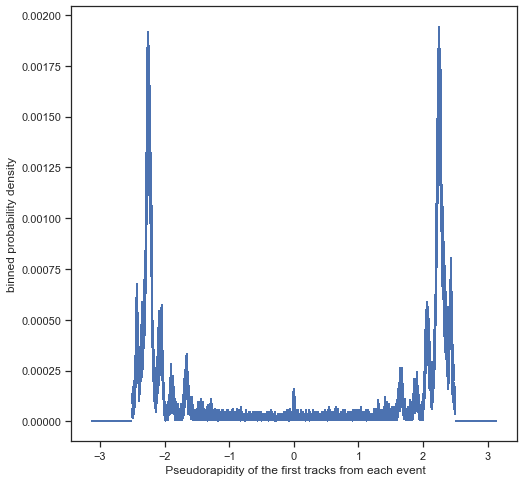

<Figure size 432x288 with 0 Axes>

In [12]:
#Plots the pseudorapidities of the b hadrons
Figure = plt.figure()
Tracks_eta = binneddensity(features["AnalysisTracks_eta"][:,0],fixedbinning(-np.pi,np.pi,10000),xlabel = " Pseudorapidity of the first tracks from each event")
Tracks_eta

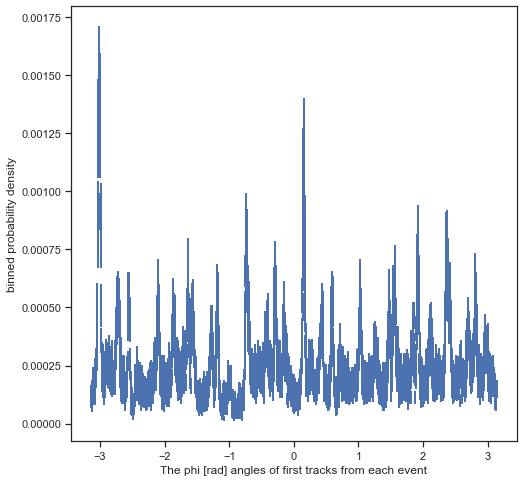

<Figure size 432x288 with 0 Axes>

In [13]:
# Plots the distributions of the phi angles of the tracks
Figure = plt.figure()
Tracks_phi = binneddensity(features["AnalysisTracks_phi"][:,0],fixedbinning(-np.pi,np.pi,4000),xlabel = "The phi [rad] angles of first tracks from each event")
Tracks_phi

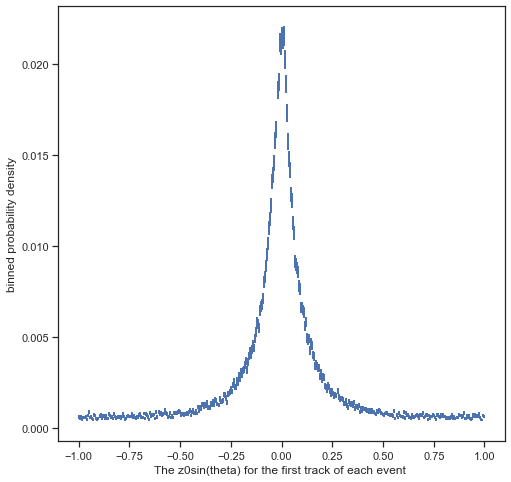

<Figure size 432x288 with 0 Axes>

In [14]:
#Plots the distribution of the component of the longitudinal impact parameter of the tracks along the xy plane
Figure = plt.figure()
Tracks_z0_sin_theta = binneddensity(features["AnalysisTracks_z0sinTheta"][:,0],fixedbinning(-1,1,400),xlabel = "The z0sin(theta) for the first track of each event ")
Tracks_z0_sin_theta

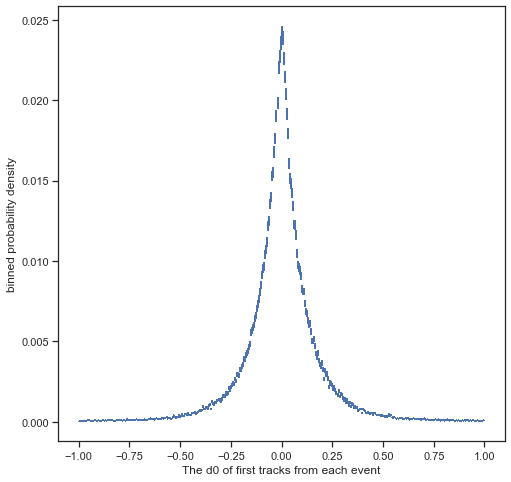

<Figure size 432x288 with 0 Axes>

In [15]:
# Plots the distribution of the transverse impact parameters of the tracks. 
Figure = plt.figure()
Tracks_z0 = binneddensity(features["AnalysisTracks_d0"][:,0],fixedbinning(-1,1,400),xlabel = "The d0 of first tracks from each event")
Tracks_z0

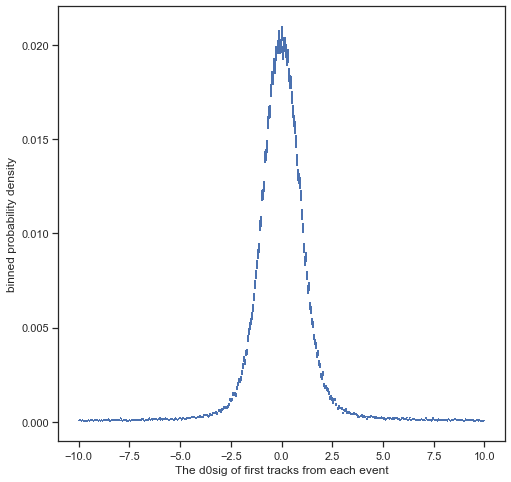

<Figure size 432x288 with 0 Axes>

In [16]:
# Plots the distribution of the transverse impact parameter significance of the tracks
Figure = plt.figure()
Tracks_pt = binneddensity(features["AnalysisTracks_d0sig"][:,0],fixedbinning(-10,10,400),xlabel = "The d0sig of first tracks from each event")
Tracks_pt

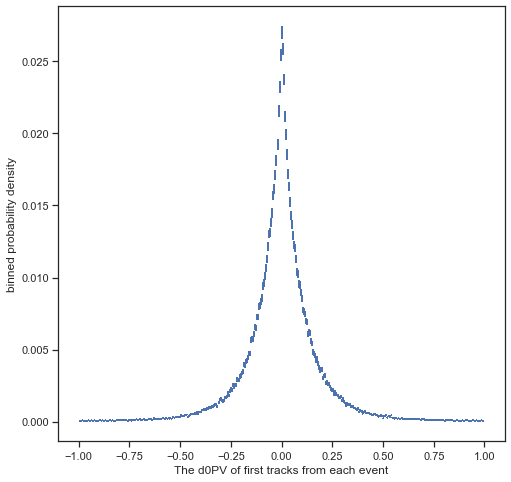

<Figure size 432x288 with 0 Axes>

In [17]:
# Plots the distribution of the transverse impact parameter significance of the tracks with respect to the primary vertex
Figure = plt.figure()
Tracks_pt = binneddensity(features["AnalysisTracks_d0PV"][:,0],fixedbinning(-1,1,400),xlabel = "The d0PV of first tracks from each event")
Tracks_pt

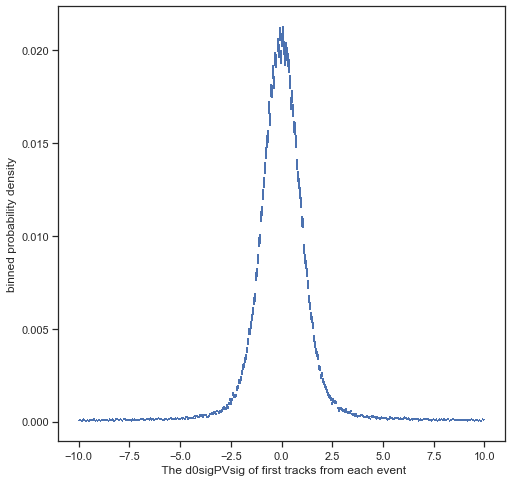

<Figure size 432x288 with 0 Axes>

In [18]:
# Plots the distribution of the tranvserse impact parameter significance with respect to the primary vertex of the tracks.
Figure = plt.figure()
Tracks_pt = binneddensity(features["AnalysisTracks_d0sigPV"][:,0],fixedbinning(-10,10,400),xlabel = " The d0sigPVsig of first tracks from each event")
Tracks_pt

In [19]:
#Select the events of interest
events = features[ak.sum(features["AnalysisAntiKt4TruthJets_pt"] > 25000, axis = 1) > 0]
#Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))

#Select tracks from the events
tracks = events[track_features]

#Match the tracks to the jets
matchedtracks = tracks[DSNNA.Match_Tracks(jets,tracks)]

#Pad and Flatten the data
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)

# Identify the the bottom jets and their associated tracks
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads = np.stack([bhads_pt,bhads_eta,bhads_phi],axis = -1)

print("There are {} outputs".format(np.shape(bhads)[1]))
matchedtracks = matchedtracks[bjets]
print("There are {} inputs".format(np.shape(matchedtracks)[1]))

#Transform the jet and tracks to unstructed data.
jets = structured_to_unstructured(jets[jet_features[:-3]])
matchedtracks = structured_to_unstructured(matchedtracks)

#Fix the angles
jets = DSNNA.pt_eta_phi_2_px_py_pz_jets(jets).to_numpy()
tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
bhads_cart = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
print(np.shape(tracks_p))
print(np.shape(matchedtracks[:, :, 3:]))
tracks = np.concatenate([tracks_p,matchedtracks[:,:,3:].to_numpy()],axis = 2)
print(np.shape(tracks))



The number of jets to train on is:  141329
There are 3 outputs
There are 32 inputs
(68143, 32, 3)
(68143, 32, 5)
(68143, 32, 8)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture.py:103: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


In [20]:
#Standardize the inputs
Scaler = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(tracks)
tracks = np.reshape(tracks, newshape=(-1,Num_features))
tracks = Scaler.fit_transform(tracks)
tracks = np.reshape(tracks, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(tracks))
print(tracks[0,0,:])

(68143, 32, 8)
[0.26189855 0.38175348 0.10230412 1.42959932 1.58783932 1.42992229
 1.60955267 1.42990682]


In [21]:
#Calculates the principle components for the track information for the first b_jet.
pca = PCA()
track_pca = pca.fit_transform(tracks[0,:,:])
component_names = [f"PC{i+1}" for i in range(track_pca.shape[1])]
tracks_pca = pd.DataFrame(track_pca, columns = component_names)
tracks_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.900449  0.164637 -0.208669 -0.033997 -0.006756  0.000481 -0.000106   
1  3.487393 -0.212849  0.215531 -0.000239 -0.004412 -0.002547 -0.000343   
2  3.781044  0.887157  0.087002  0.005943  0.002656 -0.000175  0.000095   
3  3.714828 -0.234889 -0.063624 -0.022922  0.007408 -0.000074 -0.000758   
4  3.714285 -0.265828 -0.069639 -0.005991  0.002863 -0.001410  0.001083   

            PC8  
0  7.040536e-17  
1  7.040536e-17  
2  7.040536e-17  
3  7.040536e-17  
4  7.040536e-17

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

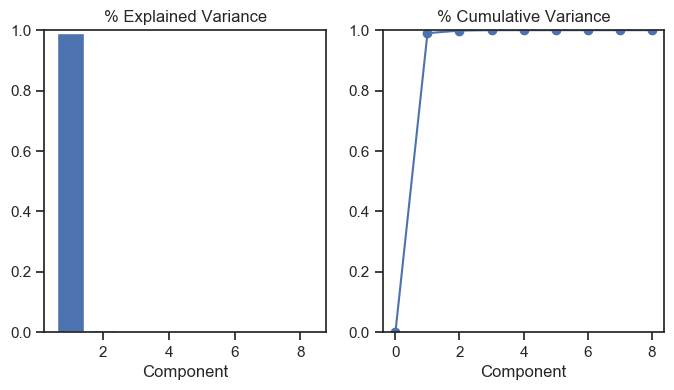

In [22]:
#Plots the principle components for the first b_jet 
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs
plot_variance(pca)

In [24]:
#Masks the -999s used to pad the tracks in the initial import
tracks = np.ma.masked_equal(tracks, -999)
matchedtracks = np.ma.masked_equal(matchedtracks,-999)
print(tracks[0,:,1])
print(matchedtracks[0,:,1])
print(np.shape(tracks))
print(np.shape(matchedtracks))

[ 0.38175348  0.10935606  1.03370324  0.05544495  0.03752739  0.07534197
  0.17838116 -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452
 -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452
 -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452
 -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452  -0.0097452
 -0.0097452  -0.0097452 ]
[0.7530462741851807 0.8005361557006836 0.8437681794166565
 0.9432456493377686 0.6490969061851501 0.952082633972168
 0.8386399149894714 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- --]
(68143, 32, 8)
(68143, 32, 8)


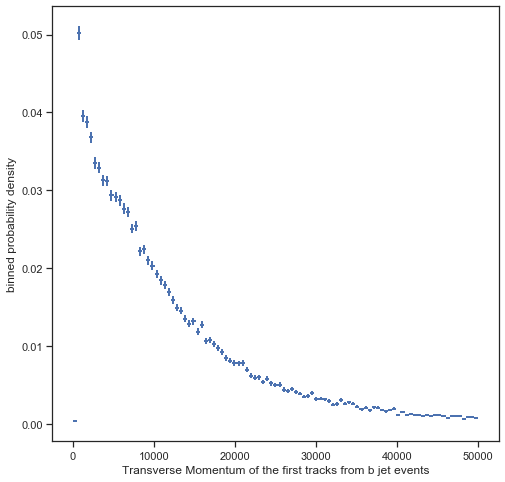

In [25]:
#Plots the distribution of the transverse momenta of the first tracks of the b_jets
binneddensity(matchedtracks[:,0,0],fixedbinning(0,50000,100),xlabel = "Transverse Momentum of the first tracks from b jet events")

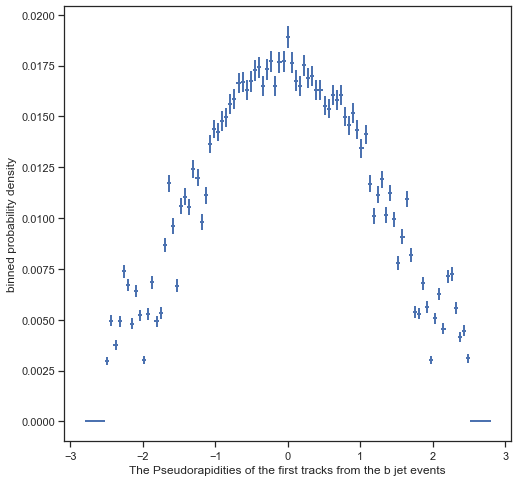

In [26]:
#Plots the distribution of the pseudorapidities of the first tracks from the b_jets events
binneddensity(matchedtracks[:,0,1],fixedbinning(-2.8,2.8,100),xlabel = "The Pseudorapidities of the first tracks from the b jet events")

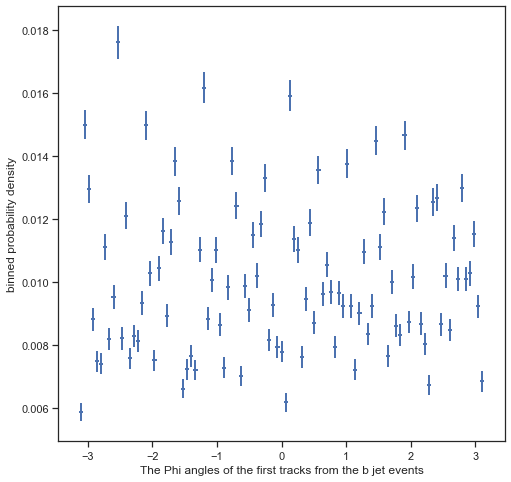

In [27]:
# Plots the distribution of the phi angles of the first tracks from the b_jets events.
binneddensity(matchedtracks[:,0,2],fixedbinning(-np.pi,np.pi,100),xlabel = "The Phi angles of the first tracks from the b jet events")

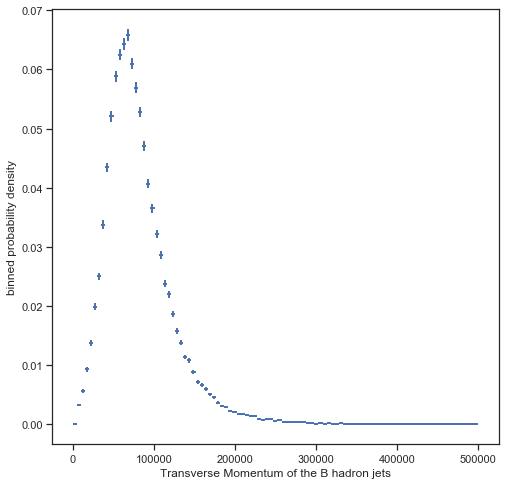

In [28]:
#Plots the distribution of the transverse momemtum of the b hadrons
binneddensity(bhads[:,0],fixedbinning(0, 500000,100),xlabel = "Transverse Momentum of the B hadron jets")

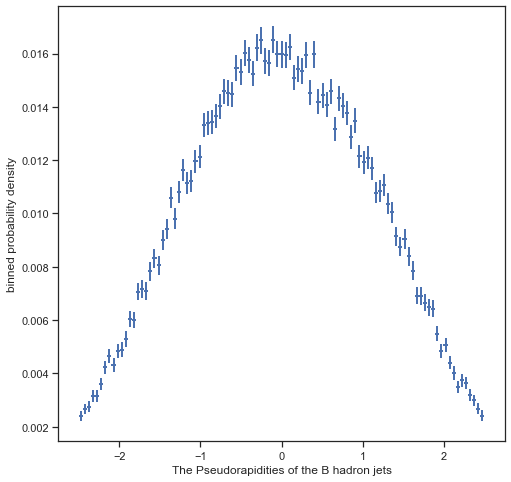

In [29]:
# Plots the distribution of the pseudorapdities of the B hadrons 
binneddensity(bhads[:,1],fixedbinning(-2.5, 2.5,100),xlabel = "The Pseudorapidities of the B hadron jets")

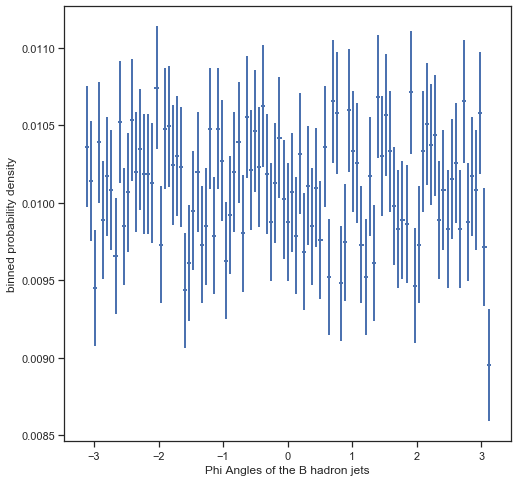

In [30]:
binneddensity(bhads[:,2],fixedbinning(-np.pi, np.pi,100),xlabel = "Phi Angles of the B hadron jets")

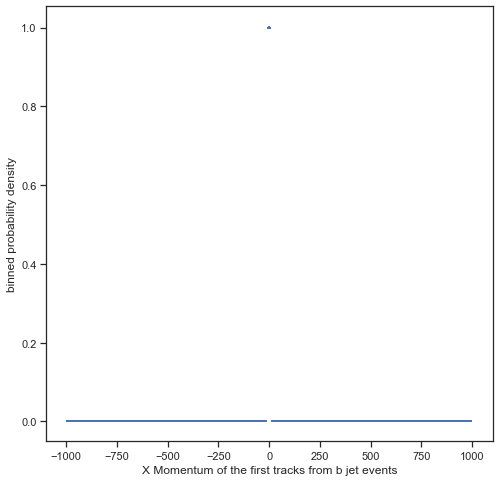

In [31]:
#Plots the distribution of the X momenta of the first tracks from the b_jets
binneddensity(tracks[:,0,0],fixedbinning(-998, 1000,100),xlabel = "X Momentum of the first tracks from b jet events")

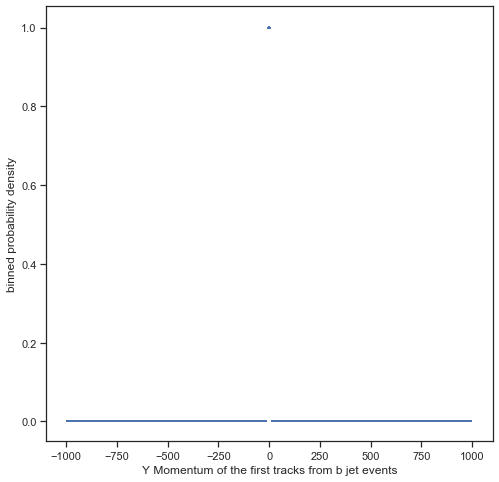

In [32]:
#Plots the distribution of the Y_momenta of the first tracks from the b_jets
binneddensity(tracks[:,0,1],fixedbinning(-998, 1000,100),xlabel = "Y Momentum of the first tracks from b jet events")

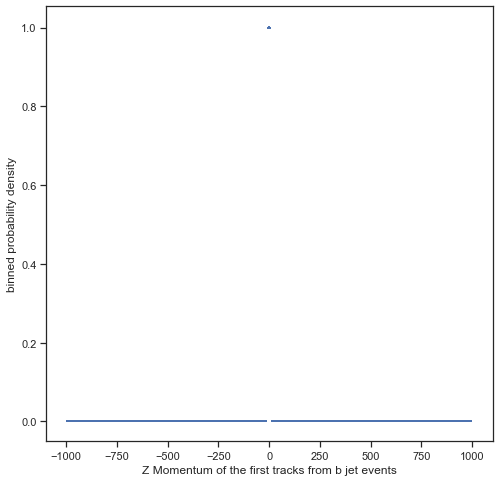

In [33]:
# Plots the distribution of the Z momenta of the first tracks from the b_jets
binneddensity(tracks[:,0,2],fixedbinning(-998, 1000,100),xlabel = "Z Momentum of the first tracks from b jet events")

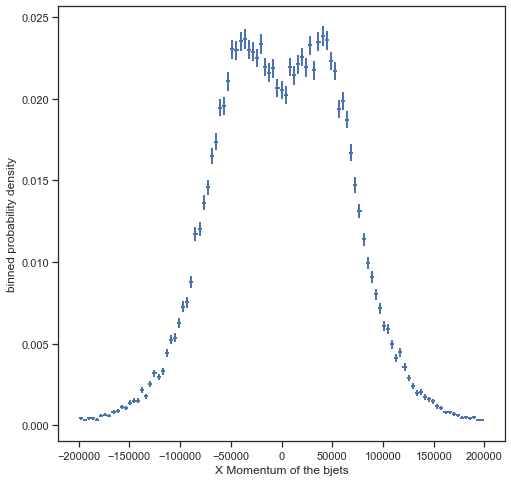

In [100]:
#Plots the distribution of the X momenta of the bhadrons
binneddensity(bhads_cart[:,0],fixedbinning(-200000, 200000,100),xlabel = "X Momentum of the bjets")

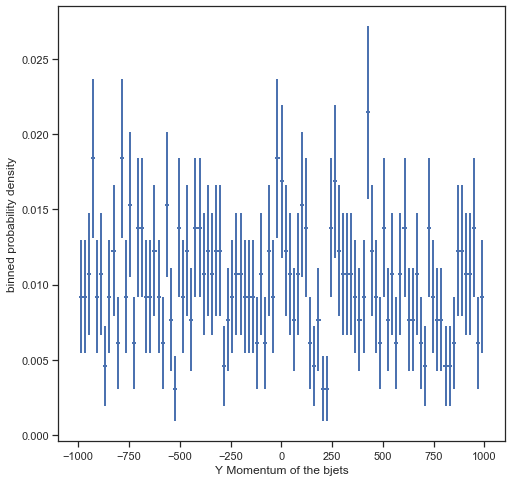

In [35]:
#Plots the distribution of the Y momenta of the b hadrons
binneddensity(bhads_cart[:,1],fixedbinning(-998, 1000,100),xlabel = "Y Momentum of the bjets")

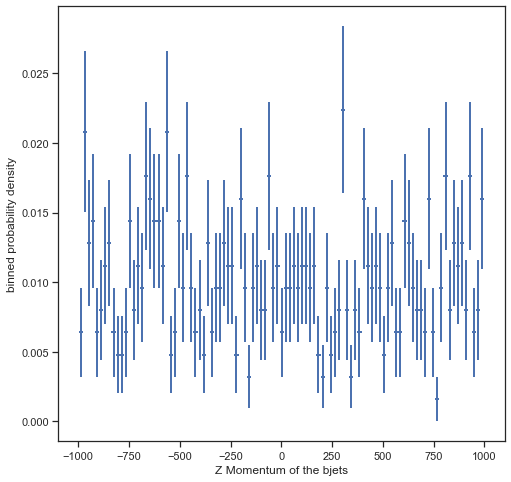

In [36]:
#Plots the distribution of the Z momenta of the first tracks from the b_jets
binneddensity(bhads_cart[:,2],fixedbinning(-998, 1000,100),xlabel = "Z Momentum of the bjets")

In [39]:
#Converts the track data, b_jet data and Bhad data into 2D dimensional arrays for analysis using pandas
Track_Data = pd.DataFrame(data = matchedtracks[:,0,:],columns = ["AnalysisTracks_pt", "AnalysisTracks_pseudorapidity", "AnalysisTracks_phi_angles", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"])
Track_Cart_Data = pd.DataFrame(data = tracks[:,0,:],columns = ["AnalysisTracks_px", "AnalysisTracks_py", "AnalysisTracks_pz", "AnalysisTracks_z0sinTheta",
                  "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"])          
Bhad_Data = pd.DataFrame(data = bhads, columns = ["Transverse Momentum","Pseudorapidity","Phi Angle"] )
Bhad_Cart_Data = pd.DataFrame(data = bhads_cart, columns = ["Momentum_px","Momentum_py","Momentum_pz"])
Track_Cart_Data["AnalysisTracks_Momenta"] = np.sqrt(Track_Cart_Data["AnalysisTracks_px"]**2 + Track_Cart_Data["AnalysisTracks_py"]**2 + Track_Cart_Data["AnalysisTracks_pz"]**2)

In [40]:
Track_Data.head()

AnalysisTracks_pt  AnalysisTracks_pseudorapidity  \
0       14728.210938                       0.753046   
1       36016.667969                       1.574784   
2        8141.662109                      -2.309198   
3        2862.209961                       0.142131   
4        7313.381836                      -0.746391   

   AnalysisTracks_phi_angles  AnalysisTracks_z0sinTheta  AnalysisTracks_d0sig  \
0                   1.135598                   1.187540             75.535919   
1                   1.563545                   0.176790             -5.868888   
2                  -2.568287                  -0.540383             19.742092   
3                  -1.146653                  -0.213600              0.751653   
4                  -1.043679                   0.029427              6.050011   

   AnalysisTracks_d0  AnalysisTracks_d0sigPV  AnalysisTracks_d0PV  
0           1.331107               85.745621             1.323915  
1          -0.082942               -7.405653            -0.083929  
2           0.509719               21.221720             0.529027  
3           0.027052                0.676754             0.023648  
4           0.128898                6.331607             0.126675

In [41]:
Track_Cart_Data.head()

AnalysisTracks_px  AnalysisTracks_py  AnalysisTracks_pz  \
0           0.261899           0.381753           0.102304   
1           0.034799           0.999790           0.668879   
2          -0.236321          -0.102944          -0.318130   
3           0.069801          -0.053645           0.008552   
4           0.165291          -0.154888          -0.042369   

   AnalysisTracks_z0sinTheta  AnalysisTracks_d0sig  AnalysisTracks_d0  \
0                   1.429599              1.587839           1.429922   
1                   1.427446              1.414472           1.426910   
2                   1.425919              1.469015           1.428173   
3                   1.426615              1.428571           1.427145   
4                   1.427133              1.439855           1.427362   

   AnalysisTracks_d0sigPV  AnalysisTracks_d0PV  AnalysisTracks_Momenta  
0                1.609553             1.429907                0.474123  
1                1.411173             1.426908                1.203408  
2                1.472139             1.428214                0.409453  
3                1.428385             1.427137                0.088448  
4                1.440428             1.427357                0.230448

In [42]:
Bhad_Data.head()

Transverse Momentum  Pseudorapidity  Phi Angle
0        137346.187500        0.816028   1.207121
1         77138.359375        1.581975   1.559862
2         98893.632812       -2.406116  -2.473726
3         31594.050781        0.112686  -1.107978
4         34662.535156       -0.701888  -0.968519

In [43]:
Bhad_Cart_Data.head()

Momentum_px    Momentum_py    Momentum_pz
0  48855.565311  128363.191604  124938.017907
1    843.456253   77133.747923  179693.161233
2 -77645.824351  -61246.033110 -543946.691984
3  14105.863721  -28270.278623    3567.737679
4  19637.044949  -28563.574866  -26376.603315

In [44]:
Track_Data.describe()

AnalysisTracks_pt  AnalysisTracks_pseudorapidity  \
count       66738.000000                   66738.000000   
mean        12885.084836                      -0.004638   
std         14511.490054                       1.160254   
min           500.322388                      -2.499928   
25%          3919.992554                      -0.853970   
50%          8653.381348                      -0.013762   
75%         16797.341309                       0.850452   
max        526063.500000                       2.499782   

       AnalysisTracks_phi_angles  AnalysisTracks_z0sinTheta  \
count               66738.000000               66738.000000   
mean                   -0.000510                  -0.005433   
std                     1.811670                   0.682878   
min                    -3.141057                  -4.996285   
25%                    -1.593016                  -0.088766   
50%                     0.004065                   0.000512   
75%                     1.558311                   0.088468   
max                     3.141564                   4.997464   

       AnalysisTracks_d0sig  AnalysisTracks_d0  AnalysisTracks_d0sigPV  \
count          66738.000000       66738.000000            66738.000000   
mean               0.057434           0.005795                0.053293   
std               15.965399           0.466321               17.939524   
min             -193.585464          -8.974319             -204.926285   
25%               -2.339169          -0.065563               -2.440143   
50%                0.020515           0.000596                0.025150   
75%                2.494241           0.066739                2.626203   
max              187.984756          20.201757              198.400864   

       AnalysisTracks_d0PV  
count         66738.000000  
mean              0.005871  
std               0.466276  
min              -8.985221  
25%              -0.064645  
50%               0.000584  
75%               0.066258  
max              20.204912

In [45]:
Track_Cart_Data.describe()

AnalysisTracks_px  AnalysisTracks_py  AnalysisTracks_pz  \
count       68143.000000       68143.000000       68143.000000   
mean            0.021946           0.016216           0.005543   
std             0.517243           0.371312           0.236010   
min           -10.365599         -10.596394          -9.883389   
25%            -0.148921          -0.107155          -0.049519   
50%             0.019973           0.013048           0.003338   
75%             0.196098           0.142309           0.060381   
max            14.942238          13.851078          10.627185   

       AnalysisTracks_z0sinTheta  AnalysisTracks_d0sig  AnalysisTracks_d0  \
count               68143.000000          68143.000000       68143.000000   
mean                    1.383187              1.383223           1.383227   
std                     0.302372              0.304220           0.302376   
min                    -0.700735             -0.700599          -0.700734   
25%                     1.426857              1.420909           1.426925   
50%                     1.427066              1.426893           1.427085   
75%                     1.427251              1.432003           1.427223   
max                     1.437714              1.827321           1.470116   

       AnalysisTracks_d0sigPV  AnalysisTracks_d0PV  AnalysisTracks_Momenta  
count            68143.000000         68143.000000            68143.000000  
mean                 1.383189             1.383227                0.446352  
std                  0.304701             0.302376                0.512500  
min                 -0.700582            -0.700734                0.004653  
25%                  1.420370             1.426926                0.133030  
50%                  1.426882             1.427086                0.297409  
75%                  1.432158             1.427222                0.580669  
max                  1.849470             1.470122               17.442216

In [46]:
Bhad_Data.describe()

Transverse Momentum  Pseudorapidity     Phi Angle
count         68143.000000    68143.000000  68143.000000
mean          82054.536180       -0.005635     -0.004479
std           42392.321525        1.224954      1.812494
min            5019.133301       -4.383445     -3.141570
25%           54308.017578       -0.873790     -1.581013
50%           74180.585938       -0.017047     -0.013233
75%          100655.160156        0.866571      1.564018
max          777955.875000        4.218462      3.141497

In [47]:
Bhad_Cart_Data.describe()

Momentum_px    Momentum_py   Momentum_pz
count   68143.000000   68143.000000  6.814300e+04
mean      112.720367     -71.421224 -6.793137e+02
std     65191.731859   65423.045860  1.976745e+05
min   -526610.789047 -467837.234722 -2.273167e+06
25%    -45323.375211  -45850.216723 -7.154900e+04
50%       -65.921698    -402.773586 -1.087164e+03
75%     45619.115852   45385.044962  7.126016e+04
max    632499.053069  777843.099727  1.827357e+06

In [48]:
Track_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68143 entries, 0 to 68142
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AnalysisTracks_pt              66738 non-null  float64
 1   AnalysisTracks_pseudorapidity  66738 non-null  float64
 2   AnalysisTracks_phi_angles      66738 non-null  float64
 3   AnalysisTracks_z0sinTheta      66738 non-null  float64
 4   AnalysisTracks_d0sig           66738 non-null  float64
 5   AnalysisTracks_d0              66738 non-null  float64
 6   AnalysisTracks_d0sigPV         66738 non-null  float64
 7   AnalysisTracks_d0PV            66738 non-null  float64
dtypes: float64(8)
memory usage: 4.2 MB


In [49]:
Track_Cart_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68143 entries, 0 to 68142
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AnalysisTracks_px          68143 non-null  float64
 1   AnalysisTracks_py          68143 non-null  float64
 2   AnalysisTracks_pz          68143 non-null  float64
 3   AnalysisTracks_z0sinTheta  68143 non-null  float64
 4   AnalysisTracks_d0sig       68143 non-null  float64
 5   AnalysisTracks_d0          68143 non-null  float64
 6   AnalysisTracks_d0sigPV     68143 non-null  float64
 7   AnalysisTracks_d0PV        68143 non-null  float64
 8   AnalysisTracks_Momenta     68143 non-null  float64
dtypes: float64(9)
memory usage: 4.7 MB


In [50]:
Bhad_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68143 entries, 0 to 68142
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Transverse Momentum  68143 non-null  float64
 1   Pseudorapidity       68143 non-null  float64
 2   Phi Angle            68143 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [51]:
Bhad_Cart_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68143 entries, 0 to 68142
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Momentum_px  68143 non-null  float64
 1   Momentum_py  68143 non-null  float64
 2   Momentum_pz  68143 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


In [52]:
Data = pd.concat([Track_Data,Bhad_Data],axis = 1)
Data_Cart = pd.concat([Track_Cart_Data,Bhad_Cart_Data], axis = 1)

In [53]:
Data = Data[Data.AnalysisTracks_pt != -999]
Data_Cart = Data_Cart[Data_Cart.AnalysisTracks_px != -999]
Data.dropna(inplace = True)
Data_Cart.dropna(inplace = True)

In [54]:
Data.head()

AnalysisTracks_pt  AnalysisTracks_pseudorapidity  \
0       14728.210938                       0.753046   
1       36016.667969                       1.574784   
2        8141.662109                      -2.309198   
3        2862.209961                       0.142131   
4        7313.381836                      -0.746391   

   AnalysisTracks_phi_angles  AnalysisTracks_z0sinTheta  AnalysisTracks_d0sig  \
0                   1.135598                   1.187540             75.535919   
1                   1.563545                   0.176790             -5.868888   
2                  -2.568287                  -0.540383             19.742092   
3                  -1.146653                  -0.213600              0.751653   
4                  -1.043679                   0.029427              6.050011   

   AnalysisTracks_d0  AnalysisTracks_d0sigPV  AnalysisTracks_d0PV  \
0           1.331107               85.745621             1.323915   
1          -0.082942               -7.405653            -0.083929   
2           0.509719               21.221720             0.529027   
3           0.027052                0.676754             0.023648   
4           0.128898                6.331607             0.126675   

   Transverse Momentum  Pseudorapidity  Phi Angle  
0        137346.187500        0.816028   1.207121  
1         77138.359375        1.581975   1.559862  
2         98893.632812       -2.406116  -2.473726  
3         31594.050781        0.112686  -1.107978  
4         34662.535156       -0.701888  -0.968519

In [55]:
Data_Cart.head()

AnalysisTracks_px  AnalysisTracks_py  AnalysisTracks_pz  \
0           0.261899           0.381753           0.102304   
1           0.034799           0.999790           0.668879   
2          -0.236321          -0.102944          -0.318130   
3           0.069801          -0.053645           0.008552   
4           0.165291          -0.154888          -0.042369   

   AnalysisTracks_z0sinTheta  AnalysisTracks_d0sig  AnalysisTracks_d0  \
0                   1.429599              1.587839           1.429922   
1                   1.427446              1.414472           1.426910   
2                   1.425919              1.469015           1.428173   
3                   1.426615              1.428571           1.427145   
4                   1.427133              1.439855           1.427362   

   AnalysisTracks_d0sigPV  AnalysisTracks_d0PV  AnalysisTracks_Momenta  \
0                1.609553             1.429907                0.474123   
1                1.411173             1.426908                1.203408   
2                1.472139             1.428214                0.409453   
3                1.428385             1.427137                0.088448   
4                1.440428             1.427357                0.230448   

    Momentum_px    Momentum_py    Momentum_pz  
0  48855.565311  128363.191604  124938.017907  
1    843.456253   77133.747923  179693.161233  
2 -77645.824351  -61246.033110 -543946.691984  
3  14105.863721  -28270.278623    3567.737679  
4  19637.044949  -28563.574866  -26376.603315

In [56]:
Track_Data = Data[["AnalysisTracks_pt","AnalysisTracks_pseudorapidity","AnalysisTracks_phi_angles","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]]
Track_Cart_Data = Data_Cart[["AnalysisTracks_px","AnalysisTracks_py","AnalysisTracks_pz","AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","AnalysisTracks_d0PV"]]
Bhad_Data = Data[["Transverse Momentum", "Pseudorapidity","Phi Angle"]]
Bhad_Cart_Data = Data_Cart[["Momentum_px","Momentum_py","Momentum_pz"]]

In [57]:
attributesA = ["AnalysisTracks_pt","AnalysisTracks_pseudorapidity","AnalysisTracks_phi_angles","Transverse Momentum"]
attributes2A = ["AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","Transverse Momentum"]

In [58]:
attributesB = ["AnalysisTracks_px","AnalysisTracks_py","AnalysisTracks_pz","Momentum_px","Momentum_py","Momentum_pz"]
attributes2B = ["AnalysisTracks_z0sinTheta","AnalysisTracks_d0sig","AnalysisTracks_d0","AnalysisTracks_d0sigPV","Momentum_px","Momentum_py","Momentum_pz"]

In [59]:
Data.AnalysisTracks_d0.describe()

count    66738.000000
mean         0.005795
std          0.466321
min         -8.974319
25%         -0.065563
50%          0.000596
75%          0.066739
max         20.201757
Name: AnalysisTracks_d0, dtype: float64

array([[<AxesSubplot:xlabel='AnalysisTracks_pt', ylabel='AnalysisTracks_pt'>,
        <AxesSubplot:xlabel='AnalysisTracks_pseudorapidity', ylabel='AnalysisTracks_pt'>,
        <AxesSubplot:xlabel='AnalysisTracks_phi_angles', ylabel='AnalysisTracks_pt'>,
        <AxesSubplot:xlabel='Transverse Momentum', ylabel='AnalysisTracks_pt'>],
       [<AxesSubplot:xlabel='AnalysisTracks_pt', ylabel='AnalysisTracks_pseudorapidity'>,
        <AxesSubplot:xlabel='AnalysisTracks_pseudorapidity', ylabel='AnalysisTracks_pseudorapidity'>,
        <AxesSubplot:xlabel='AnalysisTracks_phi_angles', ylabel='AnalysisTracks_pseudorapidity'>,
        <AxesSubplot:xlabel='Transverse Momentum', ylabel='AnalysisTracks_pseudorapidity'>],
       [<AxesSubplot:xlabel='AnalysisTracks_pt', ylabel='AnalysisTracks_phi_angles'>,
        <AxesSubplot:xlabel='AnalysisTracks_pseudorapidity', ylabel='AnalysisTracks_phi_angles'>,
        <AxesSubplot:xlabel='AnalysisTracks_phi_angles', ylabel='AnalysisTracks_phi_angles'>,
    

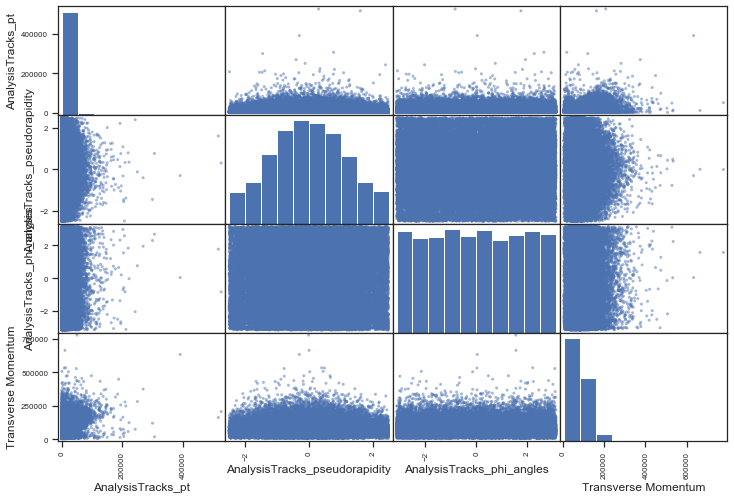

In [60]:
#Plots the scatterplots between the tracks and the bhadrons for a set of track features given by attributesA
scatter_matrix(Data[attributesA],figsize = (12,8))

array([[<AxesSubplot:xlabel='AnalysisTracks_z0sinTheta', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sig', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sigPV', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='Transverse Momentum', ylabel='AnalysisTracks_z0sinTheta'>],
       [<AxesSubplot:xlabel='AnalysisTracks_z0sinTheta', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sig', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sigPV', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='Transverse Momentum', ylabel='AnalysisTracks_d0sig'>],
       [<AxesSubplot:xlabel='AnalysisTracks_z0sinTheta', ylabel='AnalysisTracks_d0'>,
        <AxesSubplot:xlabel='AnalysisTrac

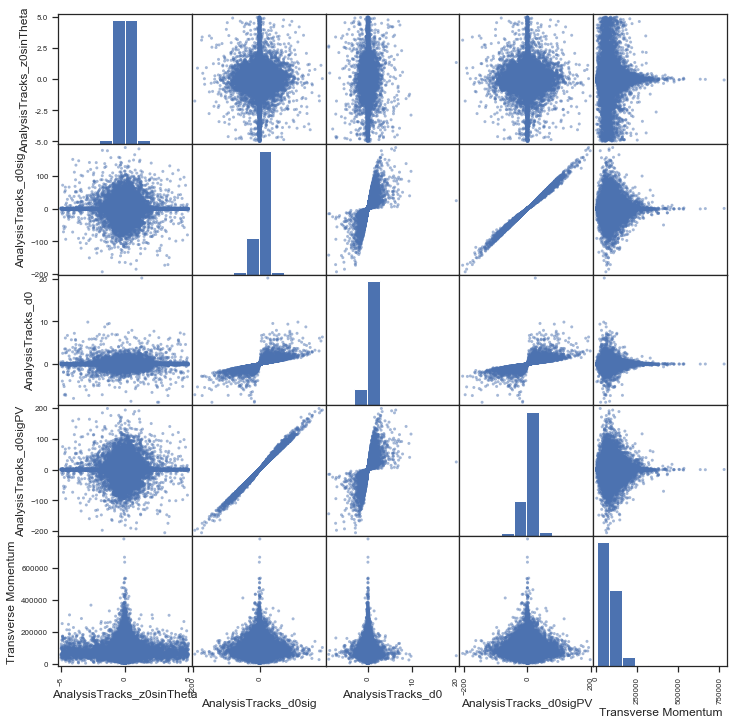

In [61]:
scatter_matrix(Data[attributes2A],figsize = (12,12))

array([[<AxesSubplot:xlabel='AnalysisTracks_px', ylabel='AnalysisTracks_px'>,
        <AxesSubplot:xlabel='AnalysisTracks_py', ylabel='AnalysisTracks_px'>,
        <AxesSubplot:xlabel='AnalysisTracks_pz', ylabel='AnalysisTracks_px'>,
        <AxesSubplot:xlabel='Momentum_px', ylabel='AnalysisTracks_px'>,
        <AxesSubplot:xlabel='Momentum_py', ylabel='AnalysisTracks_px'>,
        <AxesSubplot:xlabel='Momentum_pz', ylabel='AnalysisTracks_px'>],
       [<AxesSubplot:xlabel='AnalysisTracks_px', ylabel='AnalysisTracks_py'>,
        <AxesSubplot:xlabel='AnalysisTracks_py', ylabel='AnalysisTracks_py'>,
        <AxesSubplot:xlabel='AnalysisTracks_pz', ylabel='AnalysisTracks_py'>,
        <AxesSubplot:xlabel='Momentum_px', ylabel='AnalysisTracks_py'>,
        <AxesSubplot:xlabel='Momentum_py', ylabel='AnalysisTracks_py'>,
        <AxesSubplot:xlabel='Momentum_pz', ylabel='AnalysisTracks_py'>],
       [<AxesSubplot:xlabel='AnalysisTracks_px', ylabel='AnalysisTracks_pz'>,
        <AxesSubplot

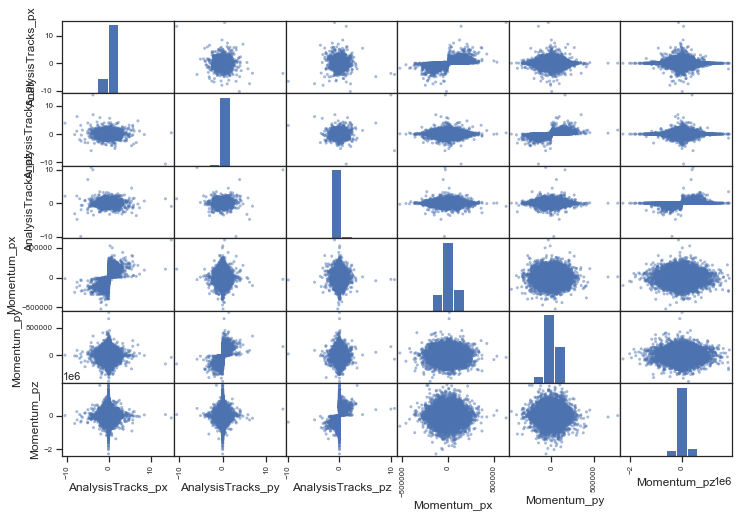

In [62]:
scatter_matrix(Data_Cart[attributesB],figsize = (12,8))

array([[<AxesSubplot:xlabel='AnalysisTracks_z0sinTheta', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sig', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sigPV', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='Momentum_px', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='Momentum_py', ylabel='AnalysisTracks_z0sinTheta'>,
        <AxesSubplot:xlabel='Momentum_pz', ylabel='AnalysisTracks_z0sinTheta'>],
       [<AxesSubplot:xlabel='AnalysisTracks_z0sinTheta', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sig', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='AnalysisTracks_d0sigPV', ylabel='AnalysisTracks_d0sig'>,
        <AxesSubplot:xlabel='Momentum_px', ylabel='Analysis

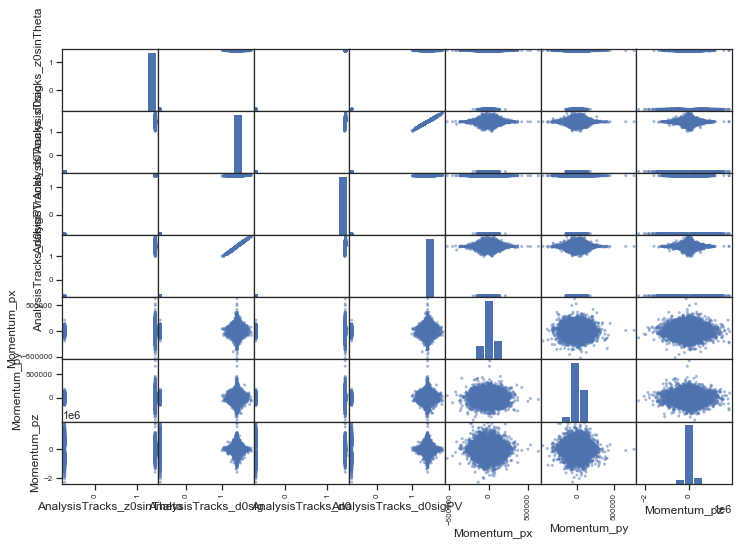

In [63]:
scatter_matrix(Data_Cart[attributes2B],figsize = (12,8))

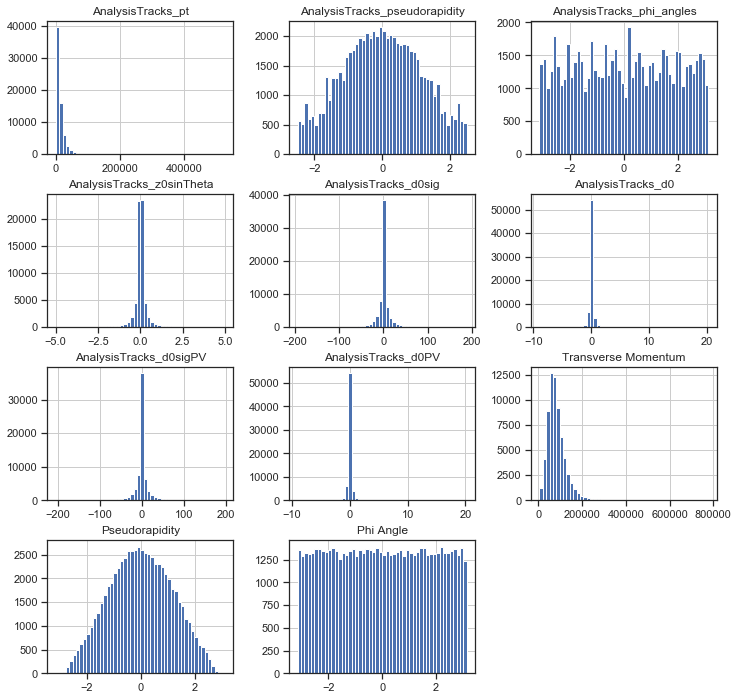

In [64]:
#Plots the different distributions of the track and bhad features.
Data.hist(bins = 50,figsize = (12,12))
plt.show()

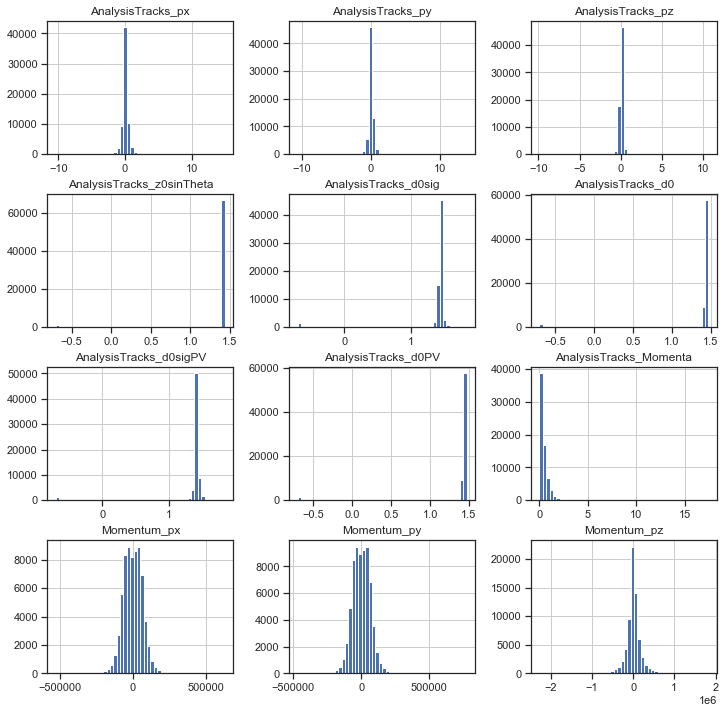

In [65]:
Data_Cart.hist(bins = 50,figsize = (12,12))
plt.show()

In [66]:
#Calculates the mi scores between the transverse momenta of the bhadrons and the track features.
mi_scores_Transverse_Momentum = make_mi_scores(Track_Data,Bhad_Data["Transverse Momentum"])
mi_scores_Transverse_Momentum

AnalysisTracks_pt                0.077303
AnalysisTracks_d0sigPV           0.013264
AnalysisTracks_d0PV              0.011495
AnalysisTracks_d0sig             0.010674
AnalysisTracks_z0sinTheta        0.003077
AnalysisTracks_phi_angles        0.001387
AnalysisTracks_d0                0.001002
AnalysisTracks_pseudorapidity    0.000236
Name: MI Scores, dtype: float64

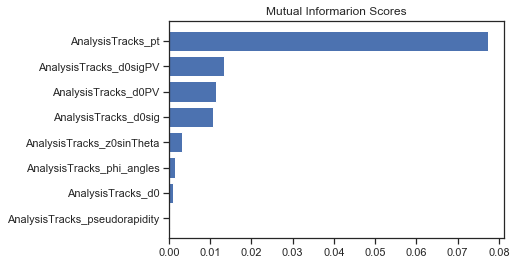

In [67]:
plt.Figure(dpi = 200,figsize = (12,12))
plot_mi_scores(mi_scores_Transverse_Momentum)

In [68]:
#Calculates the mi scores between the pseudorapidities of the bhadrons and the track features.
mi_scores_Pseudorapidity = make_mi_scores(Track_Data,Bhad_Data["Pseudorapidity"])
mi_scores_Pseudorapidity

AnalysisTracks_pseudorapidity    2.582024
AnalysisTracks_pt                0.036682
AnalysisTracks_z0sinTheta        0.020707
AnalysisTracks_phi_angles        0.010821
AnalysisTracks_d0sigPV           0.007715
AnalysisTracks_d0sig             0.004836
AnalysisTracks_d0PV              0.003493
AnalysisTracks_d0                0.000482
Name: MI Scores, dtype: float64

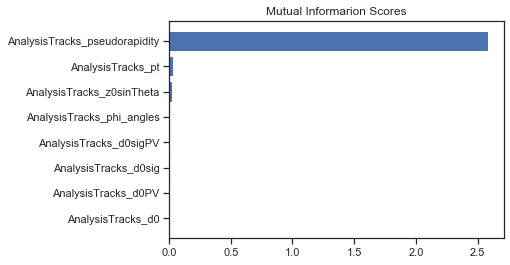

In [69]:
plt.Figure(dpi = 200, figsize = (8,5))
plot_mi_scores(mi_scores_Pseudorapidity)

In [70]:
#Calculates the mi scores between the phis of the bhadrons and the track features.
mi_scores_Phi_Angle = make_mi_scores(Track_Data,Bhad_Data["Phi Angle"])
mi_scores_Phi_Angle

AnalysisTracks_phi_angles        2.878020
AnalysisTracks_d0sigPV           0.015992
AnalysisTracks_d0sig             0.011069
AnalysisTracks_d0PV              0.010286
AnalysisTracks_d0                0.010101
AnalysisTracks_pt                0.008671
AnalysisTracks_z0sinTheta        0.007929
AnalysisTracks_pseudorapidity    0.000000
Name: MI Scores, dtype: float64

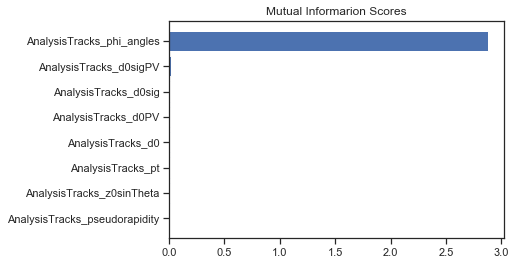

In [71]:
plt.Figure(dpi = 100, figsize = (12,12))
plot_mi_scores(mi_scores_Phi_Angle)

In [72]:
#Calculates the mi scores between the x momenta of the bhadrons and the track features.
mi_scores_Momentum_px = make_mi_scores(Track_Cart_Data,Bhad_Cart_Data["Momentum_px"])
mi_scores_Momentum_px

AnalysisTracks_px            0.862537
AnalysisTracks_py            0.028837
AnalysisTracks_d0sigPV       0.006164
AnalysisTracks_pz            0.004906
AnalysisTracks_d0sig         0.001762
AnalysisTracks_d0            0.001163
AnalysisTracks_z0sinTheta    0.000883
AnalysisTracks_d0PV          0.000000
Name: MI Scores, dtype: float64

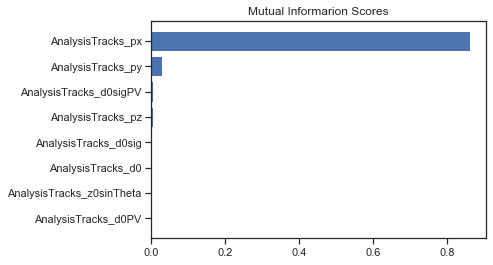

In [73]:
plt.Figure(dpi = 100, figsize = (12,12))
plot_mi_scores(mi_scores_Momentum_px)

In [74]:
# Calculates the mi scores between the Y momenta of the bhadrons and the track features
mi_scores_Momentum_py = make_mi_scores(Track_Cart_Data,Bhad_Cart_Data["Momentum_py"])
mi_scores_Momentum_py

AnalysisTracks_py            0.867904
AnalysisTracks_px            0.025029
AnalysisTracks_d0            0.005692
AnalysisTracks_d0PV          0.005437
AnalysisTracks_pz            0.004648
AnalysisTracks_d0sig         0.002157
AnalysisTracks_d0sigPV       0.001371
AnalysisTracks_z0sinTheta    0.000789
Name: MI Scores, dtype: float64

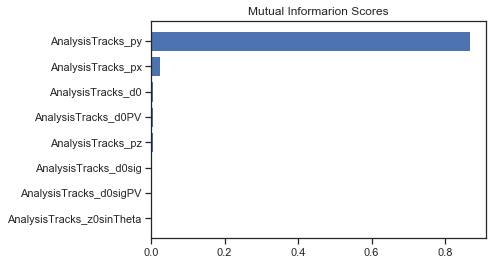

In [75]:
plt.Figure(dpi = 100, figsize = (12,12))
plot_mi_scores(mi_scores_Momentum_py)

In [76]:
# Calculates the mi scores between the Z momenta of the b hadrons and the track features.
mi_scores_Momentum_pz = make_mi_scores(Track_Cart_Data,Bhad_Cart_Data["Momentum_pz"])
mi_scores_Momentum_pz

AnalysisTracks_pz            1.012792
AnalysisTracks_z0sinTheta    0.061975
AnalysisTracks_d0sigPV       0.059915
AnalysisTracks_d0sig         0.057073
AnalysisTracks_py            0.052878
AnalysisTracks_px            0.050504
AnalysisTracks_d0PV          0.047419
AnalysisTracks_d0            0.047241
Name: MI Scores, dtype: float64

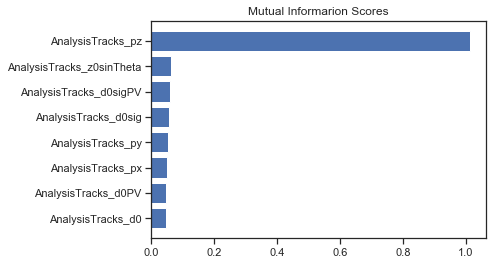

In [77]:
plt.Figure(dpi = 100, figsize = (12,12))
plot_mi_scores(mi_scores_Momentum_pz)

(68143, 32, 8)
(68143,)
68317.51904296875
[14728.2109375 3384.217041015625 39777.6875 1654.6444091796875
 745.1248779296875 2125.20849609375 5902.42578125 -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --]


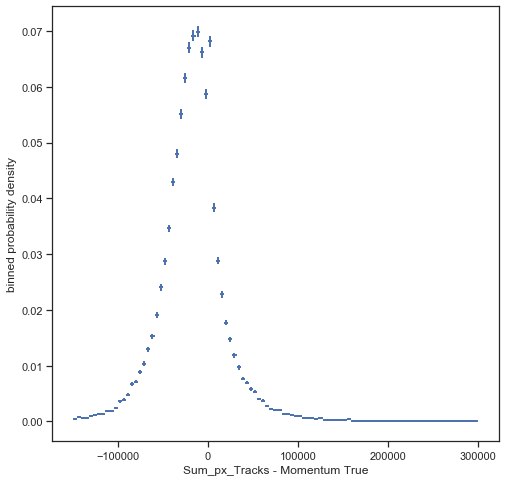

In [78]:
# Sums the tranvserse momenta of the tracks and then plots the distribution of 
# the difference between the sum of the tracks and the bhadron tranvserse momenta
sum_tracks = np.sum(matchedtracks[:,:,0],axis = 1)
print(np.shape(tracks))
print(np.shape(sum_tracks))
print(sum_tracks[0])
print(matchedtracks[0,:,0])
binneddensity(sum_tracks-bhads[:,0],fixedbinning(-150000,300000,100),xlabel ="Sum_px_Tracks - Momentum True")

[ 0.67485044 -0.20697246 -1.80736512 ...  0.03997417  0.02943062
  2.16827287]


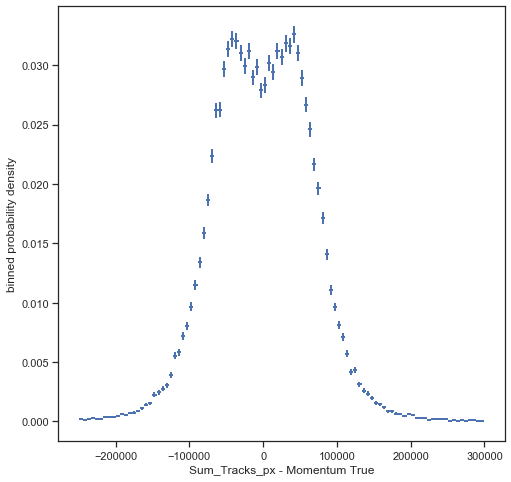

In [79]:
# Plots the distribution of the sum of the px momenta of the tracks subtracted from the bhadrons x momenta.
sum_tracks_cart_px = np.ma.sum(tracks[:,:,0],axis = 1)
print(sum_tracks_cart_px)
binneddensity(sum_tracks_cart_px-bhads_cart[:,0],fixedbinning(-250000,300000,100),xlabel ="Sum_Tracks_px - Momentum True")

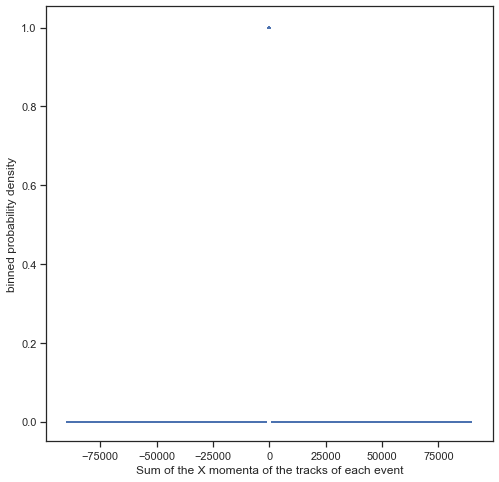

In [80]:
#Plots the distribution of the sum of the tracks px momenta
binneddensity(sum_tracks_cart_px,fixedbinning(-90000,90000,100),xlabel = "Sum of the X momenta of the tracks of each event")

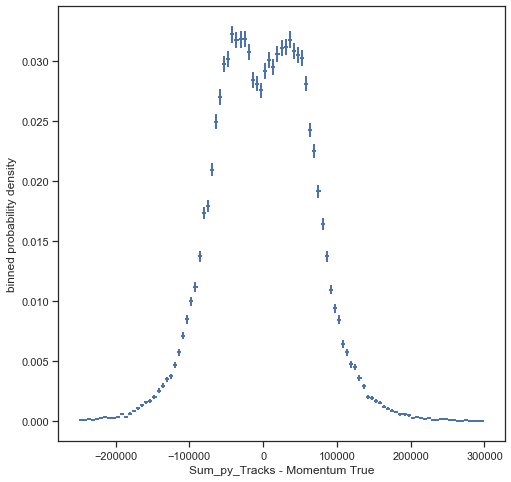

In [81]:
# Plots the distribution of the sum of the py momenta of the tracks subtracted from the bhadrons Y momenta.
sum_tracks_cart_py = np.ma.sum(tracks[:,:,1],axis = 1)
binneddensity(sum_tracks_cart_py-bhads_cart[:,1],fixedbinning(-250000,300000,100),xlabel ="Sum_py_Tracks - Momentum True")

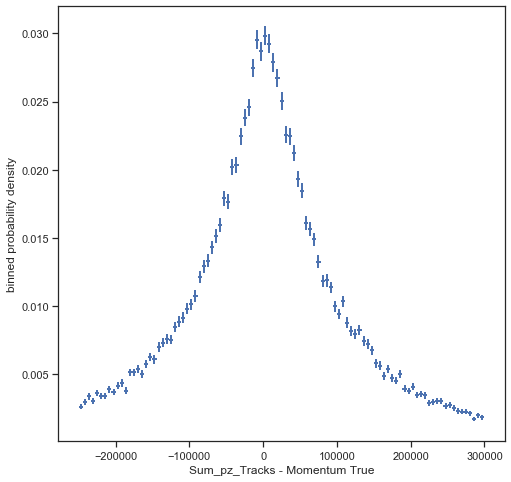

In [82]:
#Plots the distribution of the sum of the tracks pz momenta subtracted the bhadron z momenta
sum_tracks_cart_pz = np.ma.sum(tracks[:,:,2],axis = 1)
binneddensity(sum_tracks_cart_pz-bhads_cart[:,2],fixedbinning(-250000,300000,100),xlabel ="Sum_pz_Tracks - Momentum True")

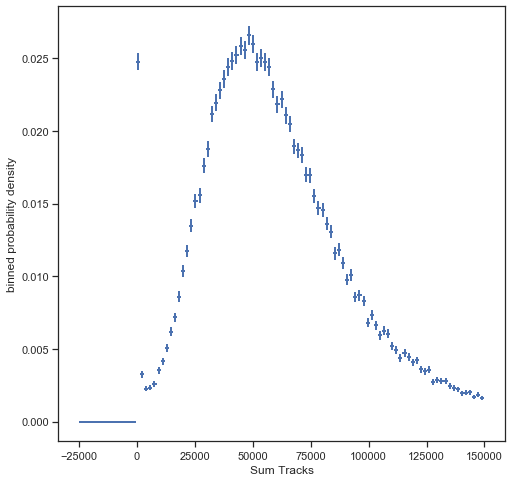

In [83]:
#Plots the distribution of the sum of the transverse momenta of the tracks
binneddensity(sum_tracks,fixedbinning(-25000,150000,100),xlabel = "Sum Tracks")

In [84]:
#Calculates the correlations between the tranvserse momenta of the bhadrons and the track features.
Covariance_matrix = Data.corr()
Covariance_matrix["Transverse Momentum"].sort_values(ascending = False)

Transverse Momentum              1.000000
AnalysisTracks_pt                0.336558
AnalysisTracks_phi_angles        0.002079
Phi Angle                        0.001107
AnalysisTracks_z0sinTheta        0.000907
Pseudorapidity                  -0.002537
AnalysisTracks_pseudorapidity   -0.002617
AnalysisTracks_d0sigPV          -0.003427
AnalysisTracks_d0sig            -0.003693
AnalysisTracks_d0               -0.007061
AnalysisTracks_d0PV             -0.007123
Name: Transverse Momentum, dtype: float64

In [85]:
#Calculates the correlations between the x momenta of the bhadrons and the track features.
Covariance_matrix = Data_Cart.corr()
Covariance_matrix["Momentum_px"].sort_values(ascending = False)

Momentum_px                  1.000000
AnalysisTracks_px            0.699286
AnalysisTracks_Momenta       0.028496
AnalysisTracks_d0sigPV       0.002948
AnalysisTracks_d0sig         0.002790
AnalysisTracks_d0            0.001655
AnalysisTracks_d0PV          0.001655
AnalysisTracks_z0sinTheta    0.001601
Momentum_pz                 -0.001279
AnalysisTracks_pz           -0.003780
Momentum_py                 -0.004468
AnalysisTracks_py           -0.008927
Name: Momentum_px, dtype: float64

In [86]:
#Calculates the correlations between the Y momenta of the bhadrons and the track features.
Covariance_matrix = Data_Cart.corr()
Covariance_matrix["Momentum_py"].sort_values(ascending = False)

Momentum_py                  1.000000
AnalysisTracks_py            0.699523
AnalysisTracks_Momenta       0.014135
AnalysisTracks_d0sig         0.003528
AnalysisTracks_d0sigPV       0.003507
AnalysisTracks_d0PV          0.003354
AnalysisTracks_d0            0.003354
AnalysisTracks_z0sinTheta    0.003329
Momentum_pz                  0.001047
AnalysisTracks_pz           -0.001245
Momentum_px                 -0.004468
AnalysisTracks_px           -0.010371
Name: Momentum_py, dtype: float64

In [87]:
#Calculates the correlations between the Z momenta of the bhadrons and the track features.
Covariance_matrix = Data_Cart.corr()
Covariance_matrix["Momentum_pz"].sort_values(ascending = False)

Momentum_pz                  1.000000
AnalysisTracks_pz            0.522248
AnalysisTracks_Momenta       0.005011
AnalysisTracks_z0sinTheta    0.002523
AnalysisTracks_d0PV          0.002509
AnalysisTracks_d0            0.002508
AnalysisTracks_d0sig         0.002268
AnalysisTracks_d0sigPV       0.002240
Momentum_py                  0.001047
AnalysisTracks_py           -0.000560
Momentum_px                 -0.001279
AnalysisTracks_px           -0.002236
Name: Momentum_pz, dtype: float64

In [ ]:
#Plots the scatterplots between targets and features

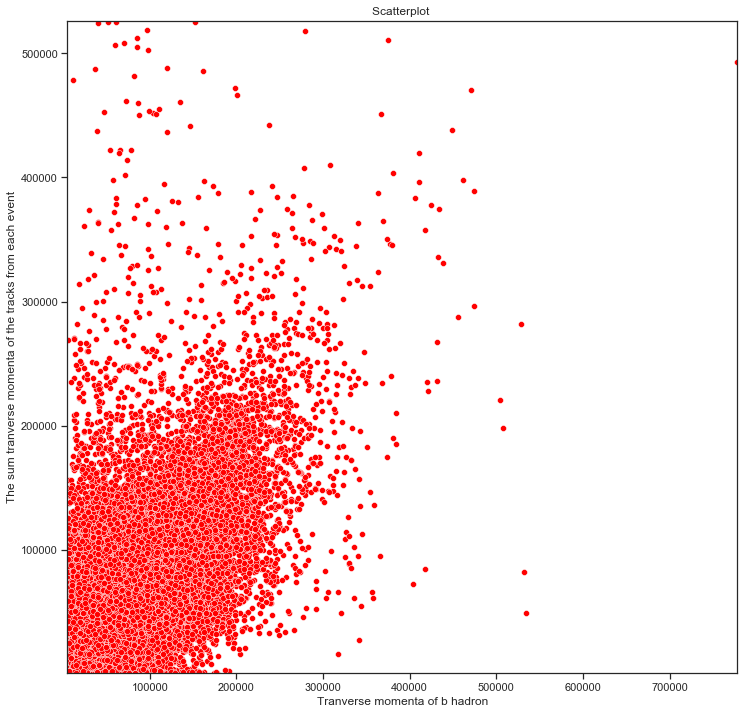

In [88]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,0],
    y = sum_tracks,
    color = "red"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads[:,0]),np.max(bhads[:,0])])
ax.set_ylim([np.min(matchedtracks[:,0,0]),np.max(matchedtracks[:,0,0])])
ax.set_ylabel("The sum tranverse momenta of the tracks from each event")
ax.set_xlabel("Tranverse momenta of b hadron")
plt.show()

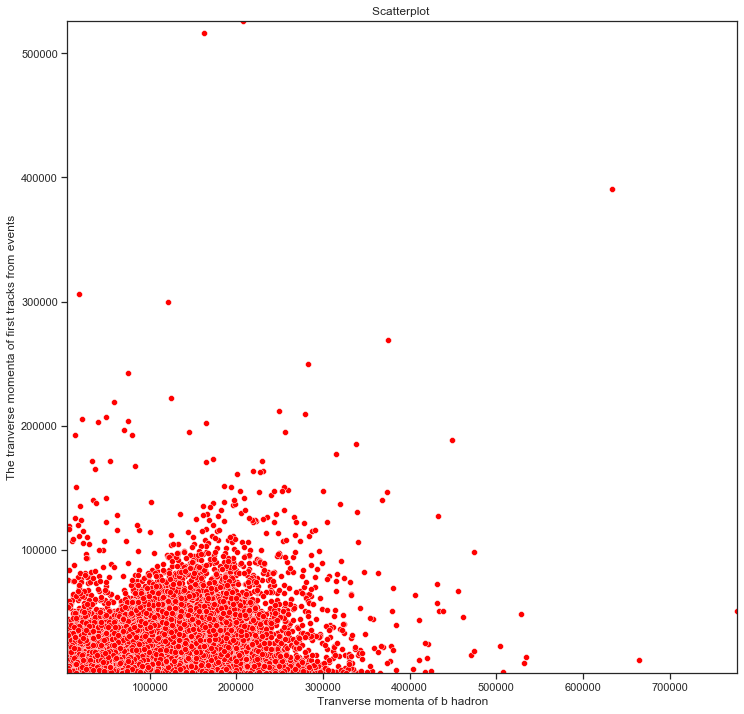

In [89]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads[:,0],
    y = matchedtracks[:,0,0],
    color = "red"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads[:,0]),np.max(bhads[:,0])])
ax.set_ylim([np.min(matchedtracks[:,0,0]),np.max(matchedtracks[:,0,0])])
ax.set_ylabel("The tranverse momenta of first tracks from events")
ax.set_xlabel("Tranverse momenta of b hadron")
plt.show()

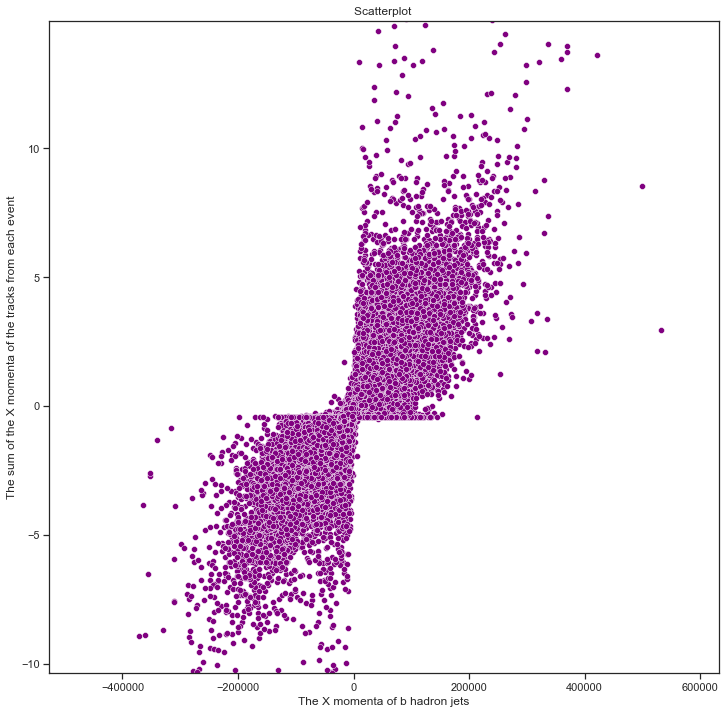

In [90]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,0],
    y = sum_tracks_cart_px,
    color = "purple"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,0]),np.max(bhads_cart[:,0])])
ax.set_ylim([np.min(tracks[:,0,0]),np.max(tracks[:,0,0])])
ax.set_ylabel("The sum of the X momenta of the tracks from each event")
ax.set_xlabel("The X momenta of b hadron jets")
plt.show()

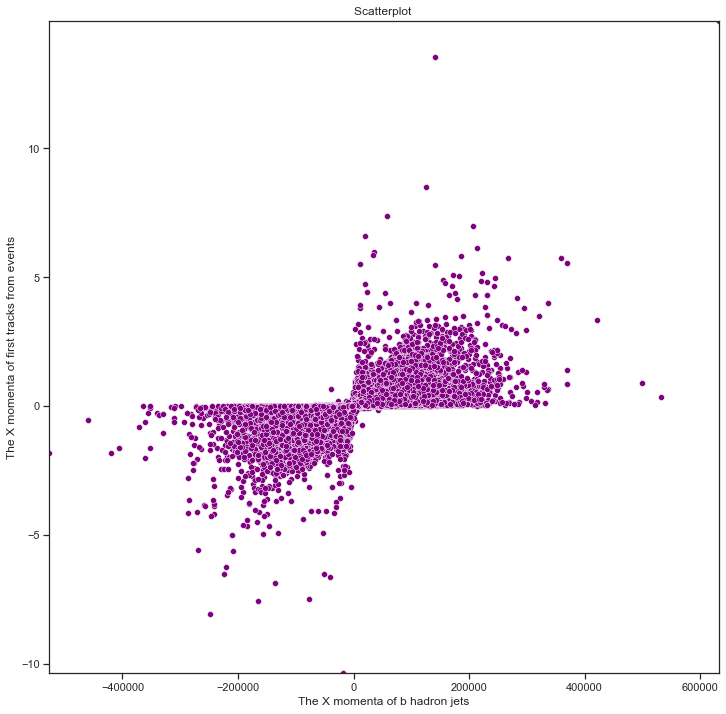

In [91]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,0],
    y = tracks[:,0,0],
    color = "purple"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,0]),np.max(bhads_cart[:,0])])
ax.set_ylim([np.min(tracks[:,0,0]),np.max(tracks[:,0,0])])
ax.set_ylabel("The X momenta of first tracks from events")
ax.set_xlabel("The X momenta of b hadron jets")
plt.show()

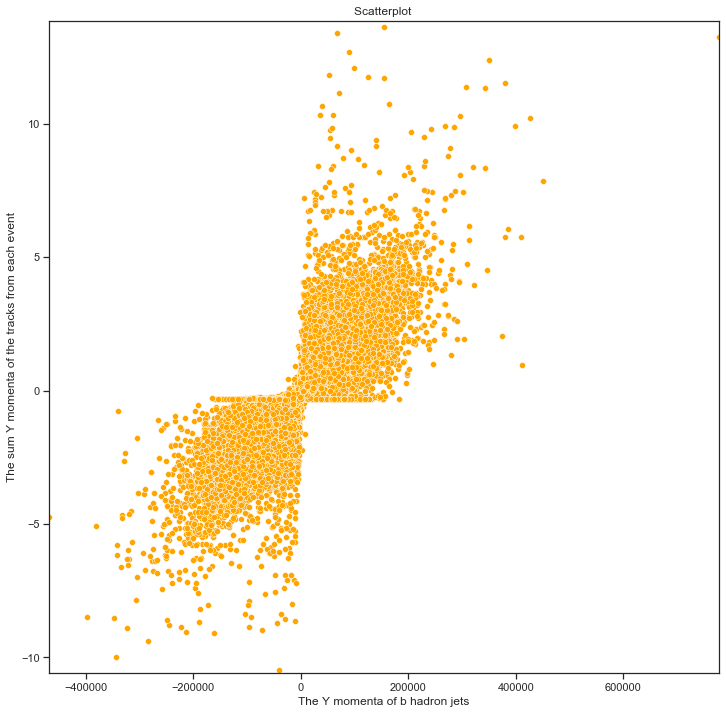

In [92]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,1],
    y = sum_tracks_cart_py,
    color = "orange"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,1]),np.max(bhads_cart[:,1])])
ax.set_ylim([np.min(tracks[:,0,1]),np.max(tracks[:,0,1])])
ax.set_ylabel("The sum Y momenta of the tracks from each event")
ax.set_xlabel("The Y momenta of b hadron jets")
plt.show()

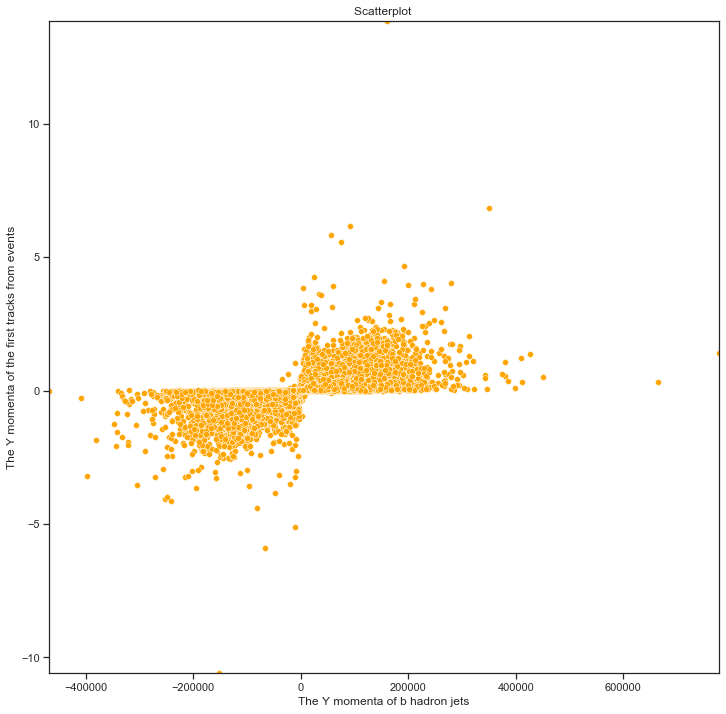

In [93]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,1],
    y = tracks[:,0,1],
    color = "orange"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,1]),np.max(bhads_cart[:,1])])
ax.set_ylim([np.min(tracks[:,0,1]),np.max(tracks[:,0,1])])
ax.set_ylabel("The Y momenta of the first tracks from events")
ax.set_xlabel("The Y momenta of b hadron jets")
plt.show()

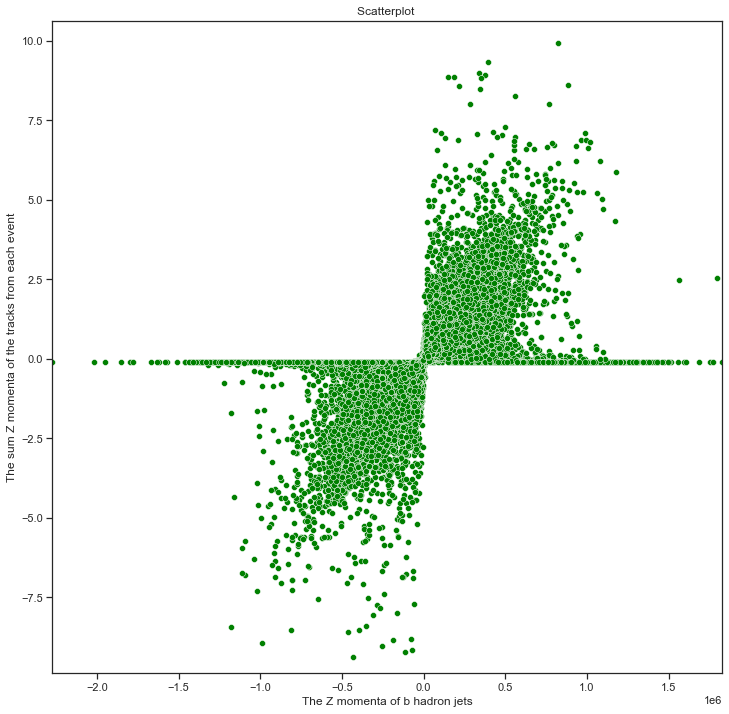

In [94]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,2],
    y = sum_tracks_cart_pz,
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,2]),np.max(bhads_cart[:,2])])
ax.set_ylim([np.min(tracks[:,0,2]),np.max(tracks[:,0,2])])
ax.set_ylabel("The sum Z momenta of the tracks from each event")
ax.set_xlabel("The Z momenta of b hadron jets")
plt.show()

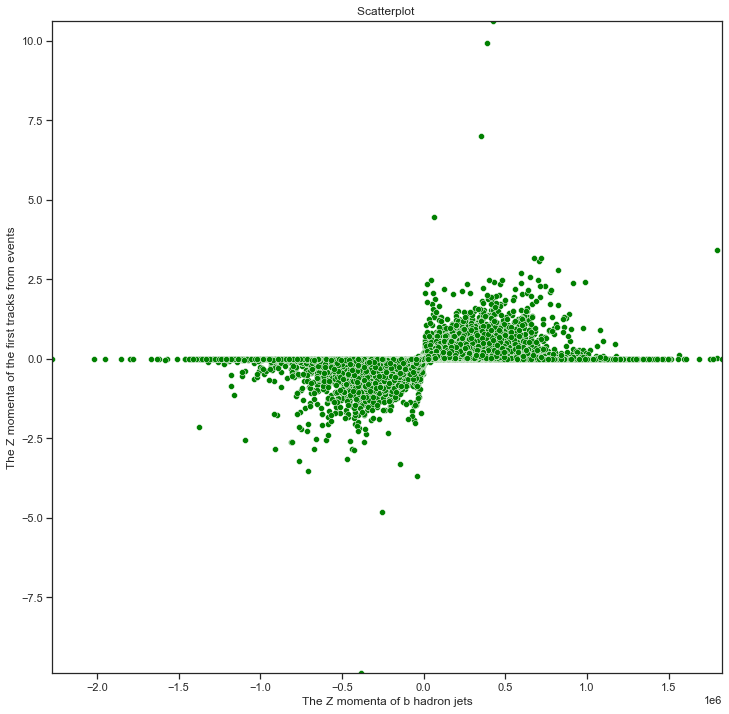

In [95]:
fig,ax = plt.subplots(figsize = (12,12))
sns.scatterplot(
    x = bhads_cart[:,2],
    y = tracks[:,0,2],
    color = "green"
)
ax.set_title("Scatterplot ")
ax.set_xlim([np.min(bhads_cart[:,2]),np.max(bhads_cart[:,2])])
ax.set_ylim([np.min(tracks[:,0,2]),np.max(tracks[:,0,2])])
ax.set_ylabel("The Z momenta of the first tracks from events")
ax.set_xlabel("The Z momenta of b hadron jets")
plt.show()